# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install pretrainedmodels

In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

# PATH = "/Users/helen/Desktop/Data/bengaliai-cv19/"
# FEATHER_PATH = "/Users/helen/Desktop/Data/bengaliaicv19feather/"

# PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliai-cv19/"
# FEATHER_PATH = "/home/chen/Work/ly/data/Bengaliai/bengaliaicv19feather/"

PATH = "/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/"
FEATHER_PATH = "/home/vemlr/Work/chen_huang/Data/bengaliaicv19feather/"

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_0.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/class_map.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_3.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_1.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/sample_submission.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test.csv
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/test_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_2.parquet
/home/vemlr/Work/chen_huang/Data/bengaliai-cv19/train_image_data_0.parquet


In [4]:
import torch

debug = False
submission=False
batch_size=96
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out='.'
image_size= 128
arch='pretrained'
model_name='se_resnext50_32x4d'

In [5]:
datadir = Path(PATH)
featherdir = Path(FEATHER_PATH)
outdir = Path('kfold_res_aug')

In [6]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [7]:
import cv2
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=image_size, pad=3, thh = 80, thl = 28):
    #crop a box around pixels large than the threshold 
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > thh)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < thl] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))


In [8]:
import numpy as np
import pandas as pd
import gc

HEIGHT = 137
WIDTH = 236

def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype('uint8') for df in image_df_list]

#     images = []
#     for df in image_df_list:
#         for idx in tqdm(range(len(df))):
#             images.append(crop_resize(df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype('uint8')))
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [9]:
%%time

# train = pd.read_csv(datadir/'train.csv')
train = pd.read_csv('train_with_fold.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0,1,2,3] #if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
CPU times: user 34.1 s, sys: 30.4 s, total: 1min 4s
Wall time: 6.88 s


In [10]:
print(len(train_labels))
print(len(train))
print(train_labels[200840-1])

200840
200840
[127   2   0]


In [11]:
 import sys 

# These are the usual ipython objects, including this one you are creating 
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars'] 

# Get a sorted list of the objects and their sizes 
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True) 

[('train_images', 6493559008),
 ('train', 39643864),
 ('HTML', 1064),
 ('KFold', 1064),
 ('Path', 896),
 ('filenames', 200),
 ('bbox', 144),
 ('crop_resize', 144),
 ('display', 144),
 ('prepare_image', 144),
 ('datadir', 120),
 ('featherdir', 120),
 ('outdir', 120),
 ('train_labels', 112),
 ('indices', 104),
 ('FEATHER_PATH', 103),
 ('PATH', 97),
 ('dirname', 97),
 ('cb', 88),
 ('ff', 88),
 ('go', 88),
 ('lgb', 88),
 ('np', 88),
 ('pd', 88),
 ('plt', 88),
 ('preprocessing', 88),
 ('px', 88),
 ('sns', 88),
 ('subplots', 88),
 ('tools', 88),
 ('xgb', 88),
 ('filename', 75),
 ('model_name', 67),
 ('arch', 59),
 ('out', 50),
 ('HEIGHT', 28),
 ('WIDTH', 28),
 ('batch_size', 28),
 ('image_size', 28),
 ('debug', 24),
 ('device', 24),
 ('submission', 24)]

<a id="dataset"></a>
# Dataset

In [12]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [13]:
import numpy as np


class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

In [14]:
train_dataset_noaug = BengaliAIDataset(train_images[:200], train_labels)

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
image, label = train_dataset_noaug[0]
print('image', image.shape, 'label', label)

image (137, 236) label [15  9  5]


In [16]:
# print(image[:5,:5])
# print(20/255)

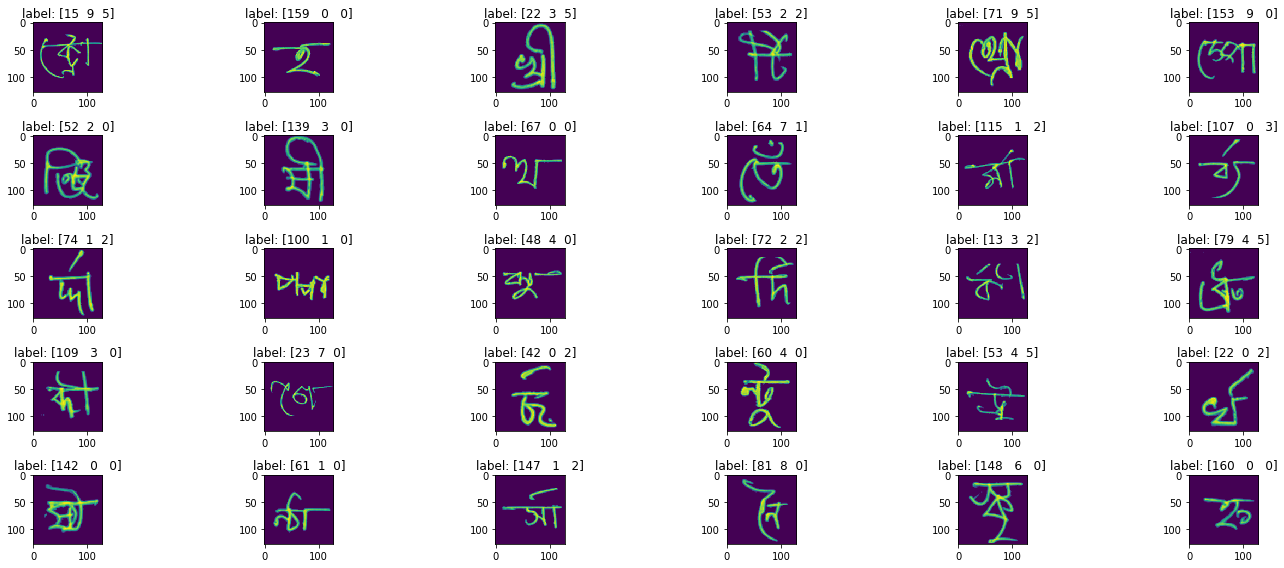

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_resize(image, thh = 80.0/255, thl=28.0/255)) #, cmap='Greys'
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import SimilarityTransform, AffineTransform, warp
import numpy as np
import math


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    if img.ndim == 3:
        img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 20
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle)*np.pi/180.0

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle)*np.pi/180.0

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)
    
#     print("rot:{}, shear:{},tx:{},ty:{}".format(rot_angle,shear_angle, tx,ty))
    
    shape = img.shape
    shape_size = shape[:2]
    center = np.float32(shape_size) / 2.
        
    pre = SimilarityTransform(translation=-center)
    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle, translation=(tx,ty)) 
    after = AffineTransform(translation=center)
    total_transform = pre+tform+after
#     total_transform = tform
    transformed_image = warp(img, total_transform.params, mode='constant')
    
    assert transformed_image.ndim == 2
    return transformed_image

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_char_image_thin(image, threshold=40./255., pad = 16):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

def crop_char_image(img0, threshold=80./255., pad=10):
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > threshold)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28./255.] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return img

def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

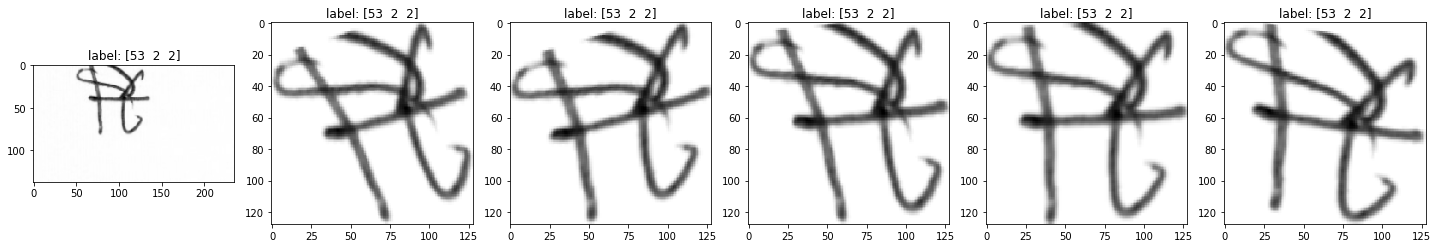

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[3]
    if i ==0:
        ax.imshow(image, cmap='Greys')
    else:
        ax.imshow(resize(crop_char_image_thin(affine_image(crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
# crop_resize(image, thh = 80.0/255, thl=28.0/255, pad=16)

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

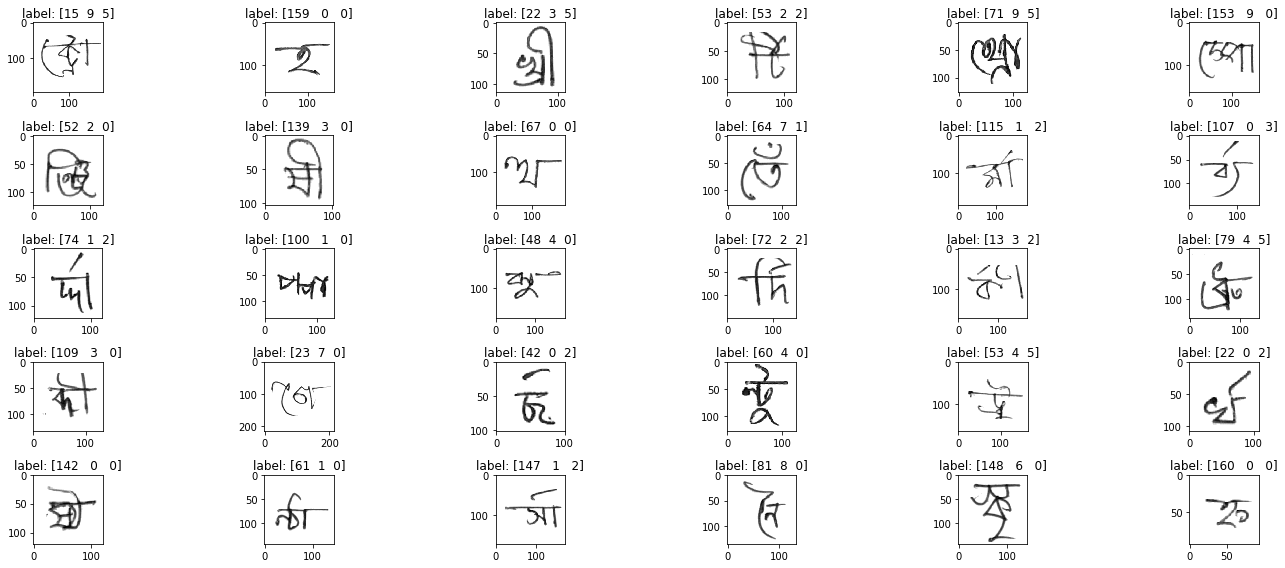

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(crop_char_image(image, threshold=80./255.), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

whole process: crop_Char_imgage->affine->crop_char_image_thin->resize

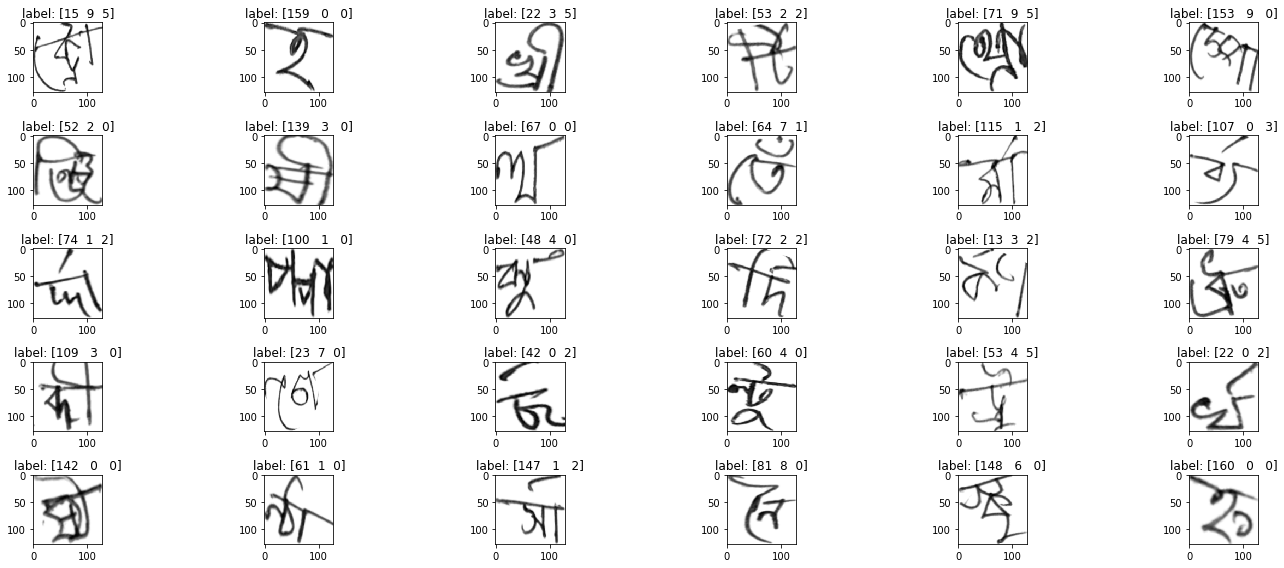

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset_noaug[i]
    ax.imshow(resize(crop_char_image_thin(affine_image((crop_char_image(image, threshold=100./255.))))), cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']

TH = 80.0

class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=TH,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
            
        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
            
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)
            
        if self.crop:
            x = crop_char_image_thin(x, threshold=self.threshold/2)        
            
        if self.size is not None:
            x = resize(x, size=self.size)
            


        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.float32)
        assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
#            x = apply_aug(A.Cutout(num_holes=1,  max_h_size=16, max_w_size=16, p=1.0),x)  # Deprecated...
             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0, mode='constant'), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=20,
                p=1.0, border_mode=cv2.BORDER_CONSTANT, value=0), x)

        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        x = x.astype(np.float32)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [23]:
train_transform = Transform(
    size=(image_size, image_size), 
    sigma=-1., blur_ratio=0.2, noise_ratio=0.1, cutout_ratio=0.5,
    grid_distortion_ratio=0.1, random_brightness_ratio=0.2,
    piece_affine_ratio=0.1, ssr_ratio=0.2, elastic_distortion_ratio=0.1) #threshold=20.,
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images[:200], train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

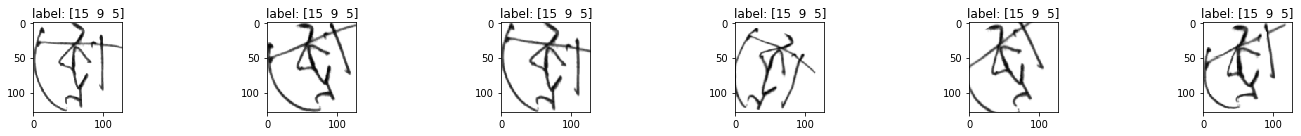

In [24]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[0]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

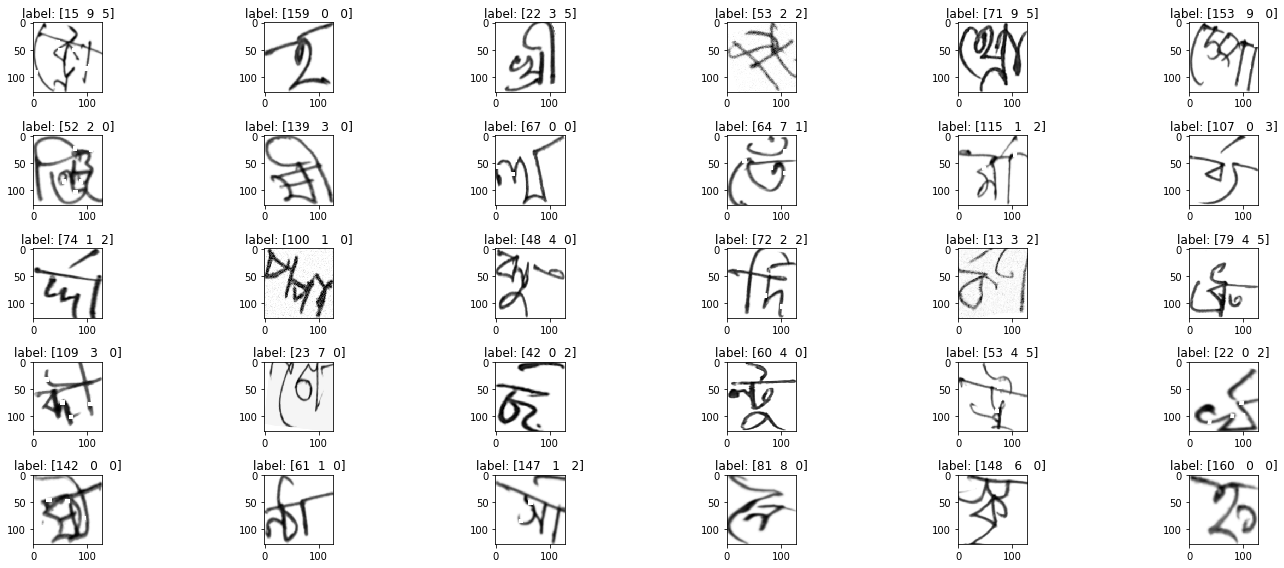

In [25]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image[0], cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
a = np.array([2,3])
b = np.array([4,5,6])

In [29]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [30]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [31]:
a = torch.Tensor([[1,2],[3,4]])
b = torch.sum(a,dim=(-1,-2))
print(b)

tensor(10.)


In [32]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='se_resnext101_32x4d',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False, dropout_ratio=0.2)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False, dropout_ratio=0.2)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

## Classifier

In [33]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    if isinstance(acc, torch.Tensor):
        acc = acc.item()
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


<a id="train"></a>
# Training code


In [34]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

def schedule_lr(metrics):
    avg_mae = metrics['loss']
    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

n_total 186


## prepare data

In [35]:
from logging import getLogger
import numpy
import os
from time import perf_counter
import argparse
from distutils.util import strtobool
import torch
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

import pandas as pd
import torch
import json


def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


In [36]:
class LogReport:
    def __init__(self, dirpath=None, logger=None):
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, epoch, iteration, train_metrics, val_metrics, mode):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': epoch,
                'iteration': iteration}
        
        elem.update({f'train/{key}': value
                     for key, value in train_metrics.items()})
        
        elem.update({f'val/{key}': value
             for key, value in val_metrics.items()})
        
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
#         print("mode in log type:{}, val:{}".format(type(mode), mode))
        elem['mode'] = str(mode)
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            elif isinstance(value, str):
                msg += f'{key} {value} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df

In [37]:
class ModelSnapshotHandler:
    def __init__(self, model, filepath='model_{count:06}.pt',
                 interval=1, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self):
        self.count += 1
        filepath = self.filepath.format(count=self.count)
        torch.save(self.model.state_dict(), filepath)

In [38]:
import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score

In [39]:
loss_recall_names =  ['loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant', 'recall']

In [40]:
def train_model(epoch, data_loader, log_report, n_train_call):
    classifier.train()
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    n_tag = 0
    for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
        n_sub = img_batch.shape[0]
        img_batch = img_batch.to(device)
        regr_batch = regr_batch.to(device)
        
        optimizer.zero_grad()
        loss, metrics, pred_y = classifier(img_batch, regr_batch)
        
        recall = macro_recall(pred_y, regr_batch)
        metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
        for key, val in metrics.items():
                metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)
                
        n_tag = n_tag + n_sub
        n_train_call[0] += n_sub
        
        loss.backward()
        optimizer.step()
        
    schedule_lr(metrics_total)
    return metrics_total, n_train_call

In [41]:
def evaluate_model(epoch, data_loader, log_report):
    classifier.eval()
    n_tag = 0
    metrics_total = dict(zip(loss_recall_names, np.zeros([len(loss_recall_names)], dtype='float32')))
    with torch.no_grad():
        for batch_idx, (img_batch, regr_batch) in enumerate(tqdm(data_loader)):
            n_sub = img_batch.shape[0]
            img_batch = img_batch.to(device)
            regr_batch = regr_batch.to(device)

            _, metrics, pred_y = classifier(img_batch, regr_batch)
        
            recall = macro_recall(pred_y, regr_batch)
            metrics_total["recall"] = (metrics_total["recall"]*n_tag+recall*n_sub)/(n_tag+n_sub)
            for key, val in metrics.items():
                    metrics_total[key] = (metrics_total[key]*n_tag+val*n_sub)/(n_tag+n_sub)

            n_tag = n_tag + n_sub
    
        return metrics_total


## Train


In [42]:
def save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall, outdir):
    mode = list("000")
    if((epoch+1)%10==0):
        model_file_name = os.path.join(outdir, 'predictor_{}_{}.pt'.format(l1,epoch))
        torch.save(predictor.state_dict(), model_file_name)
        mode[0] = "1"
    if(val_metrics['loss']<min_val_loss):
        min_val_loss = val_metrics['loss']
        if mode[0] is "0":
            model_file_name = os.path.join(outdir, 'predictor_min_loss.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[1] = "1"
    if(val_metrics['recall']>max_val_recall):
        max_val_recall = val_metrics['recall']
        if mode[0] is not "1" and mode[1] is not "1":
            model_file_name = os.path.join(outdir, 'predictor_max_recall.pt')
            torch.save(predictor.state_dict(), model_file_name)
        mode[2] = "1"
    mode = ''.join(mode)
    return mode, min_val_loss, max_val_recall

In [43]:
# mode = list("000")
# mode = ''.join(mode)
# print(mode)
# msg = ''
# key ="mode"
# value = mode
# msg += f'{key} {value}' 
# print(msg)

In [44]:
# import gc

# train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
# n_epochs = 50
# log_report = LogReport(dirpath=outdir)
# n_train_call = [0]
# min_val_loss = 1e10
# max_val_recall = 0

# for l1 in range(4):
# #     print(l1)
#     indices = [l1] #if debug else [0, 1, 2, 3]
#     train_images = prepare_image(
#         datadir, featherdir, data_type='train', submission=False, indices=indices)
#     each_part_num = 50210
#     train_labels = train_labels_total[(l1*each_part_num):((l1+1)*each_part_num)]
    
#     n_dataset = len(train_images)
#     train_data_size = 200 if debug else int(n_dataset * 0.9)
#     valid_data_size = 100 if debug else int(n_dataset - train_data_size)

#     perm = np.random.RandomState(777).permutation(n_dataset)
#     train_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#         indices=perm[:train_data_size])
#     valid_dataset = BengaliAIDataset(
#         train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#         indices=perm[train_data_size:train_data_size+valid_data_size])
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     for epoch in range(n_epochs):
#         torch.cuda.empty_cache()
#         gc.collect()
#         train_metrics = train_model(epoch, train_loader, log_report)
#         val_metrics = evaluate_model(epoch, valid_loader, log_report)
#         mode, min_val_loss, max_val_recall = save_res(predictor, l1, epoch, val_metrics, min_val_loss, max_val_recall)
# #         print("min_val_loss = ", min_val_loss)
# #         print("max_val_recall = ", max_val_recall)
#         log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)            

In [45]:
# import os
# a = "."
# b = os.path.join(a,"{}_fold".format(2))
# if not os.path.exists(b):
#     os.mkdir(b)
# print(b)
# c = os.path.join(b, 'log.json')
# print(c)

In [46]:
def save_params(outdir, k, img_size, th, arch):
    save_json(os.path.join(outdir, 'args_{}.json'.format(k)), 
              {'image_size': img_size, 
               'threshold': th, 
               'arch': arch, 
               'model_name': 'se_resnext50_32x4d'}
             )

In [47]:
def save_checkpoint(epochID, model, optimizer, scheduler, accMax, lossMIN, checkpoint_path, launchTimestamp):
    torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'max_recall': accMax, 'loss_min': lossMIN,
                            'optimizer': optimizer.state_dict(), 'scheduler':scheduler.state_dict()},
                           checkpoint_path + '/m-checkpoint.pth.tar')
#      launchTimestamp + '-' + str("%.4f" % lossMIN) +
    
def load_checkpoint(model, checkpoint_path, optimizer):
    if checkpoint_path != None:
        checkpoint_path += '/m-checkpoint.pth.tar'
        model_CKPT = torch.load(checkpoint_path)
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
        optimizer.load_state_dict(model_CKPT['optimizer'])
        epoch = model_CKPT['epoch']
        acc_Max = model_CKPT['max_recall']
        loss_MIN = model_CKPT['loss_min']
        scheduler.load_state_dict(model_CKPT['scheduler'])
    return epoch, model, optimizer, scheduler, acc_Max, loss_MIN

In [ ]:
import gc

train_labels_total = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
n_epochs = 150
kfold = 4
if not os.path.exists(outdir):
    os.mkdir(outdir)
for k in range(kfold):
    # Set pretrained='imagenet' to download imagenet pretrained model...
    predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
    print('predictor', type(predictor))
    start_time = perf_counter()
    classifier = BengaliClassifier(predictor).to(device)

    # --- Training setting ---
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=3, min_lr=1e-7)

    sub_dir = os.path.join(outdir,"{}_fold".format(k))
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)
    log_report = LogReport(dirpath=sub_dir)
    n_train_call = [0]
    min_val_loss = 1e10
    max_val_recall = 0
    val_indexes = train[train['fold']==k].index.tolist()
    train_indexes = train[train['fold']!=k].index.tolist()
    save_params(outdir, k, image_size, TH, arch)
    if debug:
        val_indexes = val_indexes[:100]
        train_indexes = train_indexes[:200]
        print("val_indexes:", val_indexes[:5])
        print("train_indexes:", train_indexes[:5])
        
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=train_transform,
        indices=train_indexes)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        indices=val_indexes)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    for epoch in range(n_epochs):
        torch.cuda.empty_cache()
        gc.collect()
        train_metrics, n_train_call = train_model(epoch, train_loader, log_report, n_train_call)
        val_metrics = evaluate_model(epoch, valid_loader, log_report)
        mode, min_val_loss, max_val_recall = save_res(predictor, k, epoch, val_metrics, min_val_loss, 
                                                      max_val_recall, sub_dir)
        save_checkpoint(epoch, predictor, optimizer, scheduler, max_val_recall, min_val_loss, sub_dir, 
                                str(int(perf_counter()- start_time)))
#         print("mode type:{}, mode val:{}".format(type(mode), mode))
#         print("min_val_loss = ", min_val_loss)
#         print("max_val_recall = ", max_val_recall)
        log_report(epoch, n_train_call[0], train_metrics, val_metrics, mode)
    
    model_file_name = os.path.join(sub_dir, 'predictor_{}_{}.pt'.format(k,epoch))
    torch.save(predictor.state_dict(), model_file_name)

predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]/home/vemlr/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples.

  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  5.027796 train/loss_grapheme  3.057012 train/loss_vowel  1.062459 train/loss_consonant  0.908326 train/acc_grapheme  0.398607 train/acc_vowel  0.685253 train/acc_consonant  0.777074 train/recall  0.444534 val/loss  1.567638 val/loss_grapheme  0.975863 val/loss_vowel  0.291236 val/loss_consonant  0.300539 val/acc_grapheme  0.843333 val/acc_vowel  0.950209 val/acc_consonant  0.942815 val/recall  0.845455 lr  0.001000 elapsed_time  608.341707 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  2.746089 train/loss_grapheme  1.744663 train/loss_vowel  0.568866 train/loss_consonant  0.432559 train/acc_grapheme  0.667584 train/acc_vowel  0.815033 train/acc_consonant  0.902547 train/recall  0.666010 val/loss  0.941206 val/loss_grapheme  0.613434 val/loss_vowel  0.156364 val/loss_consonant  0.171408 val/acc_grapheme  0.884386 val/acc_vowel  0.964574 val/acc_consonant  0.956582 val/recall  0.877035 lr  0.001000 elapsed_time  1224.487237 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  2.395407 train/loss_grapheme  1.567035 train/loss_vowel  0.472248 train/loss_consonant  0.356124 train/acc_grapheme  0.696301 train/acc_vowel  0.837601 train/acc_consonant  0.914783 train/recall  0.696500 val/loss  0.723009 val/loss_grapheme  0.482937 val/loss_vowel  0.118228 val/loss_consonant  0.121844 val/acc_grapheme  0.906617 val/acc_vowel  0.971868 val/acc_consonant  0.965694 val/recall  0.905352 lr  0.001000 elapsed_time  1846.661794 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  2.209483 train/loss_grapheme  1.460216 train/loss_vowel  0.426891 train/loss_consonant  0.322376 train/acc_grapheme  0.708257 train/acc_vowel  0.847372 train/acc_consonant  0.921772 train/recall  0.709038 val/loss  0.610850 val/loss_grapheme  0.413230 val/loss_vowel  0.104884 val/loss_consonant  0.092737 val/acc_grapheme  0.921480 val/acc_vowel  0.974557 val/acc_consonant  0.974432 val/recall  0.917470 lr  0.001000 elapsed_time  2461.935039 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  2.087862 train/loss_grapheme  1.383460 train/loss_vowel  0.400936 train/loss_consonant  0.303466 train/acc_grapheme  0.715520 train/acc_vowel  0.850553 train/acc_consonant  0.926639 train/recall  0.716928 val/loss  0.575530 val/loss_grapheme  0.392273 val/loss_vowel  0.100827 val/loss_consonant  0.082430 val/acc_grapheme  0.916351 val/acc_vowel  0.974233 val/acc_consonant  0.977420 val/recall  0.916388 lr  0.001000 elapsed_time  3073.940859 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  2.004237 train/loss_grapheme  1.335087 train/loss_vowel  0.382174 train/loss_consonant  0.286975 train/acc_grapheme  0.719839 train/acc_vowel  0.855339 train/acc_consonant  0.930299 train/recall  0.721343 val/loss  0.536290 val/loss_grapheme  0.363959 val/loss_vowel  0.088671 val/loss_consonant  0.083660 val/acc_grapheme  0.923521 val/acc_vowel  0.978739 val/acc_consonant  0.976424 val/recall  0.922533 lr  0.001000 elapsed_time  3686.400380 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  1.940554 train/loss_grapheme  1.282652 train/loss_vowel  0.373946 train/loss_consonant  0.283956 train/acc_grapheme  0.726549 train/acc_vowel  0.855787 train/acc_consonant  0.931270 train/recall  0.725693 val/loss  0.517171 val/loss_grapheme  0.354188 val/loss_vowel  0.082048 val/loss_consonant  0.080936 val/acc_grapheme  0.925737 val/acc_vowel  0.978714 val/acc_consonant  0.977544 val/recall  0.924185 lr  0.001000 elapsed_time  4298.338766 mode 011 


100%|██████████| 419/419 [01:06<00:00,  6.27it/s]


epoch      7 train/loss  1.891810 train/loss_grapheme  1.251441 train/loss_vowel  0.364700 train/loss_consonant  0.275669 train/acc_grapheme  0.728864 train/acc_vowel  0.859291 train/acc_consonant  0.932054 train/recall  0.727157 val/loss  0.503399 val/loss_grapheme  0.338603 val/loss_vowel  0.081523 val/loss_consonant  0.083273 val/acc_grapheme  0.927579 val/acc_vowel  0.979984 val/acc_consonant  0.976250 val/recall  0.923973 lr  0.001000 elapsed_time  4908.095741 mode 010 


100%|██████████| 419/419 [01:05<00:00,  6.36it/s]


epoch      8 train/loss  1.862413 train/loss_grapheme  1.239271 train/loss_vowel  0.356502 train/loss_consonant  0.266640 train/acc_grapheme  0.728814 train/acc_vowel  0.859490 train/acc_consonant  0.934282 train/recall  0.728606 val/loss  0.485006 val/loss_grapheme  0.318514 val/loss_vowel  0.090687 val/loss_consonant  0.075804 val/acc_grapheme  0.930467 val/acc_vowel  0.976748 val/acc_consonant  0.979486 val/recall  0.929001 lr  0.001000 elapsed_time  5516.935605 mode 011 


100%|██████████| 419/419 [01:04<00:00,  6.47it/s]


epoch      9 train/loss  1.839484 train/loss_grapheme  1.217231 train/loss_vowel  0.355808 train/loss_consonant  0.266444 train/acc_grapheme  0.732026 train/acc_vowel  0.859316 train/acc_consonant  0.934164 train/recall  0.730246 val/loss  0.450533 val/loss_grapheme  0.303234 val/loss_vowel  0.075839 val/loss_consonant  0.071460 val/acc_grapheme  0.934774 val/acc_vowel  0.981403 val/acc_consonant  0.979735 val/recall  0.933375 lr  0.001000 elapsed_time  6123.559542 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  1.804684 train/loss_grapheme  1.195018 train/loss_vowel  0.346144 train/loss_consonant  0.263521 train/acc_grapheme  0.734770 train/acc_vowel  0.861843 train/acc_consonant  0.935813 train/recall  0.732329 val/loss  0.440303 val/loss_grapheme  0.291501 val/loss_vowel  0.077236 val/loss_consonant  0.071567 val/acc_grapheme  0.934699 val/acc_vowel  0.980482 val/acc_consonant  0.980432 val/recall  0.932545 lr  0.001000 elapsed_time  6736.551571 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  1.786240 train/loss_grapheme  1.181164 train/loss_vowel  0.345456 train/loss_consonant  0.259619 train/acc_grapheme  0.736003 train/acc_vowel  0.861345 train/acc_consonant  0.936641 train/recall  0.733407 val/loss  0.430597 val/loss_grapheme  0.281120 val/loss_vowel  0.071380 val/loss_consonant  0.078096 val/acc_grapheme  0.937562 val/acc_vowel  0.982872 val/acc_consonant  0.977918 val/recall  0.935933 lr  0.001000 elapsed_time  7346.268436 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  1.768989 train/loss_grapheme  1.169009 train/loss_vowel  0.341737 train/loss_consonant  0.258244 train/acc_grapheme  0.737913 train/acc_vowel  0.863361 train/acc_consonant  0.937095 train/recall  0.735371 val/loss  0.438438 val/loss_grapheme  0.292351 val/loss_vowel  0.077237 val/loss_consonant  0.068850 val/acc_grapheme  0.933181 val/acc_vowel  0.980532 val/acc_consonant  0.980930 val/recall  0.931397 lr  0.001000 elapsed_time  7953.290272 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  1.757527 train/loss_grapheme  1.161389 train/loss_vowel  0.339838 train/loss_consonant  0.256301 train/acc_grapheme  0.738280 train/acc_vowel  0.863137 train/acc_consonant  0.937624 train/recall  0.735438 val/loss  0.406267 val/loss_grapheme  0.266851 val/loss_vowel  0.071982 val/loss_consonant  0.067434 val/acc_grapheme  0.939753 val/acc_vowel  0.982648 val/acc_consonant  0.980980 val/recall  0.937406 lr  0.001000 elapsed_time  8565.116027 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  1.751858 train/loss_grapheme  1.159814 train/loss_vowel  0.336358 train/loss_consonant  0.255686 train/acc_grapheme  0.738187 train/acc_vowel  0.863343 train/acc_consonant  0.937674 train/recall  0.735168 val/loss  0.441123 val/loss_grapheme  0.277431 val/loss_vowel  0.082164 val/loss_consonant  0.081528 val/acc_grapheme  0.936591 val/acc_vowel  0.979536 val/acc_consonant  0.976847 val/recall  0.932369 lr  0.001000 elapsed_time  9178.128575 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  1.737483 train/loss_grapheme  1.148072 train/loss_vowel  0.336374 train/loss_consonant  0.253037 train/acc_grapheme  0.739668 train/acc_vowel  0.863635 train/acc_consonant  0.938365 train/recall  0.736304 val/loss  0.414992 val/loss_grapheme  0.269296 val/loss_vowel  0.078062 val/loss_consonant  0.067635 val/acc_grapheme  0.938732 val/acc_vowel  0.980582 val/acc_consonant  0.981353 val/recall  0.935710 lr  0.001000 elapsed_time  9786.921089 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  1.733742 train/loss_grapheme  1.149514 train/loss_vowel  0.332247 train/loss_consonant  0.251980 train/acc_grapheme  0.739077 train/acc_vowel  0.864762 train/acc_consonant  0.938620 train/recall  0.737096 val/loss  0.407477 val/loss_grapheme  0.266585 val/loss_vowel  0.073553 val/loss_consonant  0.067339 val/acc_grapheme  0.938956 val/acc_vowel  0.982075 val/acc_consonant  0.981602 val/recall  0.938291 lr  0.001000 elapsed_time  10394.206560 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  1.720870 train/loss_grapheme  1.134085 train/loss_vowel  0.335990 train/loss_consonant  0.250796 train/acc_grapheme  0.742314 train/acc_vowel  0.862783 train/acc_consonant  0.939940 train/recall  0.738950 val/loss  0.392234 val/loss_grapheme  0.251393 val/loss_vowel  0.072090 val/loss_consonant  0.068751 val/acc_grapheme  0.943537 val/acc_vowel  0.982573 val/acc_consonant  0.981528 val/recall  0.942180 lr  0.001000 elapsed_time  11001.921990 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  1.704711 train/loss_grapheme  1.128064 train/loss_vowel  0.328644 train/loss_consonant  0.248003 train/acc_grapheme  0.743316 train/acc_vowel  0.866007 train/acc_consonant  0.940070 train/recall  0.739316 val/loss  0.397611 val/loss_grapheme  0.257990 val/loss_vowel  0.071374 val/loss_consonant  0.068246 val/acc_grapheme  0.940450 val/acc_vowel  0.982573 val/acc_consonant  0.981553 val/recall  0.937651 lr  0.001000 elapsed_time  11611.539755 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  1.708752 train/loss_grapheme  1.132738 train/loss_vowel  0.329480 train/loss_consonant  0.246534 train/acc_grapheme  0.741498 train/acc_vowel  0.863878 train/acc_consonant  0.940207 train/recall  0.738084 val/loss  0.389262 val/loss_grapheme  0.254143 val/loss_vowel  0.070590 val/loss_consonant  0.064530 val/acc_grapheme  0.941770 val/acc_vowel  0.982897 val/acc_consonant  0.982723 val/recall  0.939398 lr  0.001000 elapsed_time  12221.557537 mode 110 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  1.700948 train/loss_grapheme  1.129232 train/loss_vowel  0.326723 train/loss_consonant  0.244993 train/acc_grapheme  0.743017 train/acc_vowel  0.866492 train/acc_consonant  0.940923 train/recall  0.741744 val/loss  0.402575 val/loss_grapheme  0.256437 val/loss_vowel  0.074524 val/loss_consonant  0.071614 val/acc_grapheme  0.941272 val/acc_vowel  0.981602 val/acc_consonant  0.980631 val/recall  0.936709 lr  0.001000 elapsed_time  12829.677187 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  1.683917 train/loss_grapheme  1.116072 train/loss_vowel  0.323716 train/loss_consonant  0.244129 train/acc_grapheme  0.744704 train/acc_vowel  0.867419 train/acc_consonant  0.940960 train/recall  0.741056 val/loss  0.410123 val/loss_grapheme  0.262833 val/loss_vowel  0.073383 val/loss_consonant  0.073908 val/acc_grapheme  0.940425 val/acc_vowel  0.981702 val/acc_consonant  0.979411 val/recall  0.937655 lr  0.001000 elapsed_time  13436.754485 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  1.685889 train/loss_grapheme  1.115336 train/loss_vowel  0.325376 train/loss_consonant  0.245177 train/acc_grapheme  0.744666 train/acc_vowel  0.865415 train/acc_consonant  0.939983 train/recall  0.740105 val/loss  0.412096 val/loss_grapheme  0.266547 val/loss_vowel  0.073975 val/loss_consonant  0.071574 val/acc_grapheme  0.938981 val/acc_vowel  0.981901 val/acc_consonant  0.979611 val/recall  0.935856 lr  0.001000 elapsed_time  14043.143072 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  1.671219 train/loss_grapheme  1.104652 train/loss_vowel  0.324242 train/loss_consonant  0.242325 train/acc_grapheme  0.746882 train/acc_vowel  0.866691 train/acc_consonant  0.941558 train/recall  0.743110 val/loss  0.410316 val/loss_grapheme  0.261894 val/loss_vowel  0.074216 val/loss_consonant  0.074205 val/acc_grapheme  0.939405 val/acc_vowel  0.982225 val/acc_consonant  0.980258 val/recall  0.936541 lr  0.001000 elapsed_time  14649.498994 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  1.669278 train/loss_grapheme  1.105438 train/loss_vowel  0.322304 train/loss_consonant  0.241536 train/acc_grapheme  0.746278 train/acc_vowel  0.866697 train/acc_consonant  0.941085 train/recall  0.741997 val/loss  0.405819 val/loss_grapheme  0.260847 val/loss_vowel  0.073144 val/loss_consonant  0.071828 val/acc_grapheme  0.939355 val/acc_vowel  0.982075 val/acc_consonant  0.980855 val/recall  0.937896 lr  0.001000 elapsed_time  15257.352456 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  1.671221 train/loss_grapheme  1.106074 train/loss_vowel  0.323886 train/loss_consonant  0.241261 train/acc_grapheme  0.746546 train/acc_vowel  0.865863 train/acc_consonant  0.941757 train/recall  0.741516 val/loss  0.404237 val/loss_grapheme  0.260387 val/loss_vowel  0.075399 val/loss_consonant  0.068450 val/acc_grapheme  0.939878 val/acc_vowel  0.981901 val/acc_consonant  0.981055 val/recall  0.936885 lr  0.001000 elapsed_time  15860.554364 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  1.670368 train/loss_grapheme  1.107802 train/loss_vowel  0.321196 train/loss_consonant  0.241370 train/acc_grapheme  0.745793 train/acc_vowel  0.867482 train/acc_consonant  0.941216 train/recall  0.742731 val/loss  0.384804 val/loss_grapheme  0.245994 val/loss_vowel  0.073129 val/loss_consonant  0.065681 val/acc_grapheme  0.943438 val/acc_vowel  0.982374 val/acc_consonant  0.981727 val/recall  0.939874 lr  0.001000 elapsed_time  16467.417069 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  1.667793 train/loss_grapheme  1.107171 train/loss_vowel  0.319941 train/loss_consonant  0.240680 train/acc_grapheme  0.745463 train/acc_vowel  0.867158 train/acc_consonant  0.941135 train/recall  0.741095 val/loss  0.378493 val/loss_grapheme  0.245012 val/loss_vowel  0.071041 val/loss_consonant  0.062440 val/acc_grapheme  0.945255 val/acc_vowel  0.983445 val/acc_consonant  0.983196 val/recall  0.942410 lr  0.001000 elapsed_time  17076.735492 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  1.660791 train/loss_grapheme  1.096210 train/loss_vowel  0.321574 train/loss_consonant  0.243006 train/acc_grapheme  0.747965 train/acc_vowel  0.866486 train/acc_consonant  0.940761 train/recall  0.742643 val/loss  0.408831 val/loss_grapheme  0.254926 val/loss_vowel  0.081000 val/loss_consonant  0.072905 val/acc_grapheme  0.941944 val/acc_vowel  0.979088 val/acc_consonant  0.979984 val/recall  0.938066 lr  0.001000 elapsed_time  17685.837510 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  1.662766 train/loss_grapheme  1.101450 train/loss_vowel  0.323047 train/loss_consonant  0.238269 train/acc_grapheme  0.746795 train/acc_vowel  0.865876 train/acc_consonant  0.941452 train/recall  0.742860 val/loss  0.379960 val/loss_grapheme  0.242294 val/loss_vowel  0.066441 val/loss_consonant  0.071225 val/acc_grapheme  0.944259 val/acc_vowel  0.983718 val/acc_consonant  0.979511 val/recall  0.937542 lr  0.001000 elapsed_time  18294.727865 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  1.655968 train/loss_grapheme  1.096397 train/loss_vowel  0.319776 train/loss_consonant  0.239796 train/acc_grapheme  0.747697 train/acc_vowel  0.867245 train/acc_consonant  0.941234 train/recall  0.743459 val/loss  0.372027 val/loss_grapheme  0.240213 val/loss_vowel  0.064528 val/loss_consonant  0.067286 val/acc_grapheme  0.945130 val/acc_vowel  0.984042 val/acc_consonant  0.981428 val/recall  0.942611 lr  0.001000 elapsed_time  18903.052625 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  1.654642 train/loss_grapheme  1.101869 train/loss_vowel  0.317124 train/loss_consonant  0.235649 train/acc_grapheme  0.746658 train/acc_vowel  0.867569 train/acc_consonant  0.942896 train/recall  0.743286 val/loss  0.375192 val/loss_grapheme  0.240384 val/loss_vowel  0.068182 val/loss_consonant  0.066626 val/acc_grapheme  0.943587 val/acc_vowel  0.982673 val/acc_consonant  0.982150 val/recall  0.941377 lr  0.001000 elapsed_time  19509.660082 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  1.654392 train/loss_grapheme  1.097881 train/loss_vowel  0.318211 train/loss_consonant  0.238300 train/acc_grapheme  0.746776 train/acc_vowel  0.867226 train/acc_consonant  0.942797 train/recall  0.742293 val/loss  0.388795 val/loss_grapheme  0.255849 val/loss_vowel  0.066558 val/loss_consonant  0.066388 val/acc_grapheme  0.940923 val/acc_vowel  0.983718 val/acc_consonant  0.982299 val/recall  0.939499 lr  0.001000 elapsed_time  20120.734249 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  1.645933 train/loss_grapheme  1.090838 train/loss_vowel  0.318132 train/loss_consonant  0.236963 train/acc_grapheme  0.747952 train/acc_vowel  0.867133 train/acc_consonant  0.941819 train/recall  0.743665 val/loss  0.394239 val/loss_grapheme  0.256879 val/loss_vowel  0.072210 val/loss_consonant  0.065150 val/acc_grapheme  0.941197 val/acc_vowel  0.981328 val/acc_consonant  0.982449 val/recall  0.938110 lr  0.001000 elapsed_time  20726.996136 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  1.650502 train/loss_grapheme  1.093650 train/loss_vowel  0.318734 train/loss_consonant  0.238118 train/acc_grapheme  0.747336 train/acc_vowel  0.866567 train/acc_consonant  0.942143 train/recall  0.742993 val/loss  0.373294 val/loss_grapheme  0.242618 val/loss_vowel  0.065736 val/loss_consonant  0.064940 val/acc_grapheme  0.944135 val/acc_vowel  0.983171 val/acc_consonant  0.982349 val/recall  0.941411 lr  0.001000 elapsed_time  21335.594272 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  1.649534 train/loss_grapheme  1.091441 train/loss_vowel  0.318497 train/loss_consonant  0.239595 train/acc_grapheme  0.749160 train/acc_vowel  0.866760 train/acc_consonant  0.942137 train/recall  0.743844 val/loss  0.387647 val/loss_grapheme  0.254070 val/loss_vowel  0.066460 val/loss_consonant  0.067117 val/acc_grapheme  0.942019 val/acc_vowel  0.984440 val/acc_consonant  0.982374 val/recall  0.942286 lr  0.001000 elapsed_time  21945.494212 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  1.643849 train/loss_grapheme  1.089135 train/loss_vowel  0.318774 train/loss_consonant  0.235940 train/acc_grapheme  0.748369 train/acc_vowel  0.867152 train/acc_consonant  0.942131 train/recall  0.743246 val/loss  0.372861 val/loss_grapheme  0.242011 val/loss_vowel  0.068778 val/loss_consonant  0.062073 val/acc_grapheme  0.944035 val/acc_vowel  0.983469 val/acc_consonant  0.983743 val/recall  0.943000 lr  0.001000 elapsed_time  22557.088560 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  1.645372 train/loss_grapheme  1.092571 train/loss_vowel  0.315580 train/loss_consonant  0.237221 train/acc_grapheme  0.747847 train/acc_vowel  0.868701 train/acc_consonant  0.942467 train/recall  0.743041 val/loss  0.398813 val/loss_grapheme  0.254257 val/loss_vowel  0.074652 val/loss_consonant  0.069904 val/acc_grapheme  0.940400 val/acc_vowel  0.981901 val/acc_consonant  0.980980 val/recall  0.938294 lr  0.001000 elapsed_time  23162.972272 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  1.635068 train/loss_grapheme  1.082181 train/loss_vowel  0.316948 train/loss_consonant  0.235939 train/acc_grapheme  0.749969 train/acc_vowel  0.868359 train/acc_consonant  0.942492 train/recall  0.745248 val/loss  0.386691 val/loss_grapheme  0.248387 val/loss_vowel  0.071138 val/loss_consonant  0.067166 val/acc_grapheme  0.943836 val/acc_vowel  0.983220 val/acc_consonant  0.981976 val/recall  0.942340 lr  0.001000 elapsed_time  23770.862211 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  1.639330 train/loss_grapheme  1.089807 train/loss_vowel  0.312744 train/loss_consonant  0.236779 train/acc_grapheme  0.748986 train/acc_vowel  0.868608 train/acc_consonant  0.942305 train/recall  0.745115 val/loss  0.376637 val/loss_grapheme  0.243504 val/loss_vowel  0.071945 val/loss_consonant  0.061188 val/acc_grapheme  0.945479 val/acc_vowel  0.982922 val/acc_consonant  0.983420 val/recall  0.942332 lr  0.001000 elapsed_time  24379.715645 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  1.635950 train/loss_grapheme  1.085373 train/loss_vowel  0.315583 train/loss_consonant  0.234993 train/acc_grapheme  0.749614 train/acc_vowel  0.867743 train/acc_consonant  0.942572 train/recall  0.743866 val/loss  0.385106 val/loss_grapheme  0.248234 val/loss_vowel  0.070237 val/loss_consonant  0.066636 val/acc_grapheme  0.944160 val/acc_vowel  0.982673 val/acc_consonant  0.981254 val/recall  0.941460 lr  0.001000 elapsed_time  24988.274453 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  1.625488 train/loss_grapheme  1.077229 train/loss_vowel  0.313073 train/loss_consonant  0.235186 train/acc_grapheme  0.750579 train/acc_vowel  0.868589 train/acc_consonant  0.943369 train/recall  0.745011 val/loss  0.381582 val/loss_grapheme  0.244078 val/loss_vowel  0.072808 val/loss_consonant  0.064697 val/acc_grapheme  0.943462 val/acc_vowel  0.981777 val/acc_consonant  0.982822 val/recall  0.941618 lr  0.001000 elapsed_time  25596.164240 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  1.627914 train/loss_grapheme  1.081210 train/loss_vowel  0.311574 train/loss_consonant  0.235130 train/acc_grapheme  0.749216 train/acc_vowel  0.868988 train/acc_consonant  0.942635 train/recall  0.744880 val/loss  0.383988 val/loss_grapheme  0.247564 val/loss_vowel  0.072509 val/loss_consonant  0.063915 val/acc_grapheme  0.943438 val/acc_vowel  0.982648 val/acc_consonant  0.981951 val/recall  0.940636 lr  0.001000 elapsed_time  26202.562170 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  1.636856 train/loss_grapheme  1.089183 train/loss_vowel  0.314268 train/loss_consonant  0.233405 train/acc_grapheme  0.748313 train/acc_vowel  0.867973 train/acc_consonant  0.943400 train/recall  0.744154 val/loss  0.368826 val/loss_grapheme  0.241944 val/loss_vowel  0.063821 val/loss_consonant  0.063060 val/acc_grapheme  0.946525 val/acc_vowel  0.984913 val/acc_consonant  0.982922 val/recall  0.943843 lr  0.001000 elapsed_time  26809.365321 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  1.624056 train/loss_grapheme  1.075874 train/loss_vowel  0.313256 train/loss_consonant  0.234926 train/acc_grapheme  0.751257 train/acc_vowel  0.868029 train/acc_consonant  0.943095 train/recall  0.746176 val/loss  0.374970 val/loss_grapheme  0.239923 val/loss_vowel  0.067617 val/loss_consonant  0.067430 val/acc_grapheme  0.943587 val/acc_vowel  0.984042 val/acc_consonant  0.982200 val/recall  0.943212 lr  0.001000 elapsed_time  27417.038896 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  1.634407 train/loss_grapheme  1.087999 train/loss_vowel  0.312814 train/loss_consonant  0.233595 train/acc_grapheme  0.748494 train/acc_vowel  0.868577 train/acc_consonant  0.942859 train/recall  0.744789 val/loss  0.395890 val/loss_grapheme  0.255259 val/loss_vowel  0.068746 val/loss_consonant  0.071885 val/acc_grapheme  0.942168 val/acc_vowel  0.983146 val/acc_consonant  0.980681 val/recall  0.937154 lr  0.001000 elapsed_time  28026.693758 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  1.627541 train/loss_grapheme  1.080260 train/loss_vowel  0.314615 train/loss_consonant  0.232666 train/acc_grapheme  0.749739 train/acc_vowel  0.867662 train/acc_consonant  0.944054 train/recall  0.745639 val/loss  0.363688 val/loss_grapheme  0.235885 val/loss_vowel  0.067267 val/loss_consonant  0.060536 val/acc_grapheme  0.945454 val/acc_vowel  0.983544 val/acc_consonant  0.983942 val/recall  0.943096 lr  0.001000 elapsed_time  28634.772542 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  1.625262 train/loss_grapheme  1.079870 train/loss_vowel  0.312144 train/loss_consonant  0.233248 train/acc_grapheme  0.749907 train/acc_vowel  0.869760 train/acc_consonant  0.942933 train/recall  0.746628 val/loss  0.396752 val/loss_grapheme  0.255126 val/loss_vowel  0.074997 val/loss_consonant  0.066629 val/acc_grapheme  0.942566 val/acc_vowel  0.981279 val/acc_consonant  0.982050 val/recall  0.938824 lr  0.001000 elapsed_time  29240.268310 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  1.631073 train/loss_grapheme  1.085559 train/loss_vowel  0.312706 train/loss_consonant  0.232808 train/acc_grapheme  0.748737 train/acc_vowel  0.866909 train/acc_consonant  0.943711 train/recall  0.745026 val/loss  0.361669 val/loss_grapheme  0.232526 val/loss_vowel  0.067810 val/loss_consonant  0.061333 val/acc_grapheme  0.946375 val/acc_vowel  0.983544 val/acc_consonant  0.983868 val/recall  0.943209 lr  0.001000 elapsed_time  29848.753686 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  1.557613 train/loss_grapheme  1.039043 train/loss_vowel  0.295834 train/loss_consonant  0.222736 train/acc_grapheme  0.757711 train/acc_vowel  0.872342 train/acc_consonant  0.947390 train/recall  0.754232 val/loss  0.346519 val/loss_grapheme  0.221277 val/loss_vowel  0.061665 val/loss_consonant  0.063577 val/acc_grapheme  0.950259 val/acc_vowel  0.985411 val/acc_consonant  0.982573 val/recall  0.946996 lr  0.000700 elapsed_time  30458.179403 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  1.540595 train/loss_grapheme  1.027670 train/loss_vowel  0.292754 train/loss_consonant  0.220171 train/acc_grapheme  0.759479 train/acc_vowel  0.873450 train/acc_consonant  0.947085 train/recall  0.754307 val/loss  0.337153 val/loss_grapheme  0.218601 val/loss_vowel  0.061433 val/loss_consonant  0.057119 val/acc_grapheme  0.950383 val/acc_vowel  0.985610 val/acc_consonant  0.984615 val/recall  0.947339 lr  0.000700 elapsed_time  31065.268593 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  1.546239 train/loss_grapheme  1.031855 train/loss_vowel  0.294663 train/loss_consonant  0.219722 train/acc_grapheme  0.758732 train/acc_vowel  0.871820 train/acc_consonant  0.947458 train/recall  0.754705 val/loss  0.328813 val/loss_grapheme  0.213037 val/loss_vowel  0.057780 val/loss_consonant  0.057997 val/acc_grapheme  0.951454 val/acc_vowel  0.986208 val/acc_consonant  0.984963 val/recall  0.948601 lr  0.000700 elapsed_time  31673.879523 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  1.533834 train/loss_grapheme  1.024260 train/loss_vowel  0.292334 train/loss_consonant  0.217240 train/acc_grapheme  0.760388 train/acc_vowel  0.873705 train/acc_consonant  0.947732 train/recall  0.754647 val/loss  0.354283 val/loss_grapheme  0.228612 val/loss_vowel  0.064037 val/loss_consonant  0.061633 val/acc_grapheme  0.949089 val/acc_vowel  0.985436 val/acc_consonant  0.983694 val/recall  0.946659 lr  0.000700 elapsed_time  32280.790092 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  1.543492 train/loss_grapheme  1.031842 train/loss_vowel  0.294257 train/loss_consonant  0.217393 train/acc_grapheme  0.758664 train/acc_vowel  0.872510 train/acc_consonant  0.948267 train/recall  0.754750 val/loss  0.339926 val/loss_grapheme  0.218263 val/loss_vowel  0.059630 val/loss_consonant  0.062032 val/acc_grapheme  0.950259 val/acc_vowel  0.985959 val/acc_consonant  0.983544 val/recall  0.947809 lr  0.000700 elapsed_time  32888.801418 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  1.537294 train/loss_grapheme  1.030083 train/loss_vowel  0.291819 train/loss_consonant  0.215391 train/acc_grapheme  0.759242 train/acc_vowel  0.873251 train/acc_consonant  0.947931 train/recall  0.754652 val/loss  0.332515 val/loss_grapheme  0.212766 val/loss_vowel  0.061008 val/loss_consonant  0.058741 val/acc_grapheme  0.951080 val/acc_vowel  0.986133 val/acc_consonant  0.983942 val/recall  0.948851 lr  0.000700 elapsed_time  33493.743841 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  1.538460 train/loss_grapheme  1.028246 train/loss_vowel  0.292700 train/loss_consonant  0.217514 train/acc_grapheme  0.759796 train/acc_vowel  0.872430 train/acc_consonant  0.947489 train/recall  0.754764 val/loss  0.339541 val/loss_grapheme  0.217120 val/loss_vowel  0.063727 val/loss_consonant  0.058695 val/acc_grapheme  0.950931 val/acc_vowel  0.986059 val/acc_consonant  0.984266 val/recall  0.947959 lr  0.000700 elapsed_time  34102.774968 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  1.544555 train/loss_grapheme  1.032822 train/loss_vowel  0.293777 train/loss_consonant  0.217956 train/acc_grapheme  0.758116 train/acc_vowel  0.872118 train/acc_consonant  0.948149 train/recall  0.754939 val/loss  0.339231 val/loss_grapheme  0.219848 val/loss_vowel  0.060950 val/loss_consonant  0.058433 val/acc_grapheme  0.949985 val/acc_vowel  0.985312 val/acc_consonant  0.984391 val/recall  0.947436 lr  0.000700 elapsed_time  34707.890464 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  1.480340 train/loss_grapheme  0.991285 train/loss_vowel  0.282233 train/loss_consonant  0.206823 train/acc_grapheme  0.766176 train/acc_vowel  0.875112 train/acc_consonant  0.950645 train/recall  0.762346 val/loss  0.319064 val/loss_grapheme  0.202296 val/loss_vowel  0.059614 val/loss_consonant  0.057154 val/acc_grapheme  0.954242 val/acc_vowel  0.986034 val/acc_consonant  0.985660 val/recall  0.951526 lr  0.000490 elapsed_time  35314.262893 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  1.477623 train/loss_grapheme  0.990886 train/loss_vowel  0.280620 train/loss_consonant  0.206117 train/acc_grapheme  0.765927 train/acc_vowel  0.875834 train/acc_consonant  0.950832 train/recall  0.762601 val/loss  0.325221 val/loss_grapheme  0.209014 val/loss_vowel  0.060599 val/loss_consonant  0.055608 val/acc_grapheme  0.952524 val/acc_vowel  0.986407 val/acc_consonant  0.985735 val/recall  0.949966 lr  0.000490 elapsed_time  35922.212293 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  1.473522 train/loss_grapheme  0.983714 train/loss_vowel  0.281519 train/loss_consonant  0.208290 train/acc_grapheme  0.767576 train/acc_vowel  0.875286 train/acc_consonant  0.950240 train/recall  0.761953 val/loss  0.312938 val/loss_grapheme  0.199427 val/loss_vowel  0.057065 val/loss_consonant  0.056445 val/acc_grapheme  0.953794 val/acc_vowel  0.986930 val/acc_consonant  0.985362 val/recall  0.950635 lr  0.000490 elapsed_time  36524.591623 mode 110 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  1.478225 train/loss_grapheme  0.990682 train/loss_vowel  0.279863 train/loss_consonant  0.207680 train/acc_grapheme  0.766101 train/acc_vowel  0.876786 train/acc_consonant  0.950302 train/recall  0.761945 val/loss  0.309857 val/loss_grapheme  0.201284 val/loss_vowel  0.055526 val/loss_consonant  0.053048 val/acc_grapheme  0.953894 val/acc_vowel  0.987727 val/acc_consonant  0.986432 val/recall  0.952333 lr  0.000490 elapsed_time  37132.767458 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  1.470771 train/loss_grapheme  0.989261 train/loss_vowel  0.276720 train/loss_consonant  0.204790 train/acc_grapheme  0.766431 train/acc_vowel  0.875797 train/acc_consonant  0.951392 train/recall  0.762281 val/loss  0.314426 val/loss_grapheme  0.206890 val/loss_vowel  0.054105 val/loss_consonant  0.053431 val/acc_grapheme  0.952500 val/acc_vowel  0.987652 val/acc_consonant  0.986357 val/recall  0.950895 lr  0.000490 elapsed_time  37738.901697 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  1.474956 train/loss_grapheme  0.989050 train/loss_vowel  0.279438 train/loss_consonant  0.206468 train/acc_grapheme  0.766425 train/acc_vowel  0.876257 train/acc_consonant  0.950576 train/recall  0.762352 val/loss  0.315075 val/loss_grapheme  0.203473 val/loss_vowel  0.055641 val/loss_consonant  0.055962 val/acc_grapheme  0.954665 val/acc_vowel  0.987801 val/acc_consonant  0.985411 val/recall  0.952356 lr  0.000490 elapsed_time  38346.018921 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  1.473044 train/loss_grapheme  0.988220 train/loss_vowel  0.278397 train/loss_consonant  0.206428 train/acc_grapheme  0.767091 train/acc_vowel  0.876494 train/acc_consonant  0.950172 train/recall  0.762062 val/loss  0.329099 val/loss_grapheme  0.208758 val/loss_vowel  0.062125 val/loss_consonant  0.058216 val/acc_grapheme  0.952051 val/acc_vowel  0.986034 val/acc_consonant  0.984266 val/recall  0.947422 lr  0.000490 elapsed_time  38950.406000 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  1.476650 train/loss_grapheme  0.990647 train/loss_vowel  0.279905 train/loss_consonant  0.206098 train/acc_grapheme  0.765491 train/acc_vowel  0.875162 train/acc_consonant  0.950315 train/recall  0.760692 val/loss  0.321437 val/loss_grapheme  0.206899 val/loss_vowel  0.057194 val/loss_consonant  0.057344 val/acc_grapheme  0.954566 val/acc_vowel  0.986905 val/acc_consonant  0.985237 val/recall  0.952396 lr  0.000490 elapsed_time  39558.084625 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  1.471789 train/loss_grapheme  0.989229 train/loss_vowel  0.277164 train/loss_consonant  0.205396 train/acc_grapheme  0.765970 train/acc_vowel  0.876805 train/acc_consonant  0.950956 train/recall  0.762346 val/loss  0.324961 val/loss_grapheme  0.206995 val/loss_vowel  0.061621 val/loss_consonant  0.056345 val/acc_grapheme  0.953570 val/acc_vowel  0.986034 val/acc_consonant  0.984391 val/recall  0.950345 lr  0.000490 elapsed_time  40163.936781 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  1.434222 train/loss_grapheme  0.966893 train/loss_vowel  0.271061 train/loss_consonant  0.196268 train/acc_grapheme  0.770732 train/acc_vowel  0.877651 train/acc_consonant  0.953620 train/recall  0.767415 val/loss  0.297053 val/loss_grapheme  0.190427 val/loss_vowel  0.054952 val/loss_consonant  0.051674 val/acc_grapheme  0.957578 val/acc_vowel  0.988125 val/acc_consonant  0.986830 val/recall  0.955471 lr  0.000343 elapsed_time  40769.549577 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  1.431933 train/loss_grapheme  0.962397 train/loss_vowel  0.269433 train/loss_consonant  0.200102 train/acc_grapheme  0.771012 train/acc_vowel  0.878386 train/acc_consonant  0.952836 train/recall  0.766612 val/loss  0.300616 val/loss_grapheme  0.193377 val/loss_vowel  0.054252 val/loss_consonant  0.052986 val/acc_grapheme  0.955537 val/acc_vowel  0.987776 val/acc_consonant  0.986805 val/recall  0.952724 lr  0.000343 elapsed_time  41378.621855 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  1.416900 train/loss_grapheme  0.951968 train/loss_vowel  0.269346 train/loss_consonant  0.195585 train/acc_grapheme  0.772692 train/acc_vowel  0.876842 train/acc_consonant  0.953489 train/recall  0.768357 val/loss  0.300321 val/loss_grapheme  0.190719 val/loss_vowel  0.055196 val/loss_consonant  0.054406 val/acc_grapheme  0.956806 val/acc_vowel  0.987527 val/acc_consonant  0.986432 val/recall  0.953951 lr  0.000343 elapsed_time  41985.107227 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  1.430333 train/loss_grapheme  0.964392 train/loss_vowel  0.268251 train/loss_consonant  0.197689 train/acc_grapheme  0.769755 train/acc_vowel  0.879332 train/acc_consonant  0.953128 train/recall  0.767588 val/loss  0.304050 val/loss_grapheme  0.197144 val/loss_vowel  0.053180 val/loss_consonant  0.053725 val/acc_grapheme  0.956035 val/acc_vowel  0.987951 val/acc_consonant  0.986731 val/recall  0.954260 lr  0.000343 elapsed_time  42591.920221 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  1.422989 train/loss_grapheme  0.961525 train/loss_vowel  0.266511 train/loss_consonant  0.194953 train/acc_grapheme  0.770894 train/acc_vowel  0.880172 train/acc_consonant  0.953508 train/recall  0.767533 val/loss  0.300054 val/loss_grapheme  0.193670 val/loss_vowel  0.054005 val/loss_consonant  0.052379 val/acc_grapheme  0.957080 val/acc_vowel  0.987826 val/acc_consonant  0.986830 val/recall  0.955019 lr  0.000343 elapsed_time  43198.429854 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  1.423120 train/loss_grapheme  0.957156 train/loss_vowel  0.268508 train/loss_consonant  0.197455 train/acc_grapheme  0.771043 train/acc_vowel  0.878504 train/acc_consonant  0.952804 train/recall  0.767559 val/loss  0.296658 val/loss_grapheme  0.188954 val/loss_vowel  0.053823 val/loss_consonant  0.053881 val/acc_grapheme  0.957504 val/acc_vowel  0.988000 val/acc_consonant  0.986332 val/recall  0.955008 lr  0.000343 elapsed_time  43806.687789 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  1.414021 train/loss_grapheme  0.951613 train/loss_vowel  0.265052 train/loss_consonant  0.197355 train/acc_grapheme  0.773097 train/acc_vowel  0.879033 train/acc_consonant  0.952804 train/recall  0.769131 val/loss  0.298219 val/loss_grapheme  0.192242 val/loss_vowel  0.053482 val/loss_consonant  0.052496 val/acc_grapheme  0.957553 val/acc_vowel  0.987403 val/acc_consonant  0.986980 val/recall  0.955100 lr  0.000343 elapsed_time  44414.278125 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  1.424487 train/loss_grapheme  0.962332 train/loss_vowel  0.267378 train/loss_consonant  0.194777 train/acc_grapheme  0.771167 train/acc_vowel  0.879550 train/acc_consonant  0.953751 train/recall  0.768409 val/loss  0.305938 val/loss_grapheme  0.195395 val/loss_vowel  0.056679 val/loss_consonant  0.053864 val/acc_grapheme  0.955860 val/acc_vowel  0.987577 val/acc_consonant  0.986382 val/recall  0.953302 lr  0.000343 elapsed_time  45020.683328 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  1.413357 train/loss_grapheme  0.948102 train/loss_vowel  0.268030 train/loss_consonant  0.197225 train/acc_grapheme  0.774310 train/acc_vowel  0.878697 train/acc_consonant  0.953228 train/recall  0.769554 val/loss  0.311548 val/loss_grapheme  0.199084 val/loss_vowel  0.055492 val/loss_consonant  0.056972 val/acc_grapheme  0.955786 val/acc_vowel  0.988000 val/acc_consonant  0.986332 val/recall  0.954248 lr  0.000343 elapsed_time  45628.857926 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  1.410990 train/loss_grapheme  0.946949 train/loss_vowel  0.266441 train/loss_consonant  0.197600 train/acc_grapheme  0.773825 train/acc_vowel  0.878205 train/acc_consonant  0.952462 train/recall  0.769064 val/loss  0.315532 val/loss_grapheme  0.200624 val/loss_vowel  0.056268 val/loss_consonant  0.058640 val/acc_grapheme  0.954616 val/acc_vowel  0.987826 val/acc_consonant  0.985735 val/recall  0.952986 lr  0.000343 elapsed_time  46236.937276 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  1.413229 train/loss_grapheme  0.952752 train/loss_vowel  0.264012 train/loss_consonant  0.196465 train/acc_grapheme  0.772381 train/acc_vowel  0.880085 train/acc_consonant  0.953184 train/recall  0.768044 val/loss  0.303407 val/loss_grapheme  0.193202 val/loss_vowel  0.054186 val/loss_consonant  0.056019 val/acc_grapheme  0.956956 val/acc_vowel  0.988150 val/acc_consonant  0.985635 val/recall  0.954051 lr  0.000343 elapsed_time  46845.100019 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  1.419056 train/loss_grapheme  0.958684 train/loss_vowel  0.265503 train/loss_consonant  0.194869 train/acc_grapheme  0.771391 train/acc_vowel  0.879431 train/acc_consonant  0.953931 train/recall  0.768867 val/loss  0.305205 val/loss_grapheme  0.194281 val/loss_vowel  0.054793 val/loss_consonant  0.056131 val/acc_grapheme  0.957230 val/acc_vowel  0.988075 val/acc_consonant  0.986133 val/recall  0.954775 lr  0.000343 elapsed_time  47450.481381 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  1.415975 train/loss_grapheme  0.953430 train/loss_vowel  0.266090 train/loss_consonant  0.196455 train/acc_grapheme  0.772935 train/acc_vowel  0.878535 train/acc_consonant  0.953676 train/recall  0.767773 val/loss  0.308210 val/loss_grapheme  0.196275 val/loss_vowel  0.056187 val/loss_consonant  0.055748 val/acc_grapheme  0.956134 val/acc_vowel  0.987204 val/acc_consonant  0.986830 val/recall  0.953767 lr  0.000343 elapsed_time  48058.836627 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  1.404996 train/loss_grapheme  0.947079 train/loss_vowel  0.262667 train/loss_consonant  0.195251 train/acc_grapheme  0.773657 train/acc_vowel  0.879562 train/acc_consonant  0.953620 train/recall  0.770162 val/loss  0.306044 val/loss_grapheme  0.195515 val/loss_vowel  0.054971 val/loss_consonant  0.055559 val/acc_grapheme  0.956134 val/acc_vowel  0.987478 val/acc_consonant  0.986332 val/recall  0.953497 lr  0.000343 elapsed_time  48664.010640 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  1.413924 train/loss_grapheme  0.951829 train/loss_vowel  0.266974 train/loss_consonant  0.195120 train/acc_grapheme  0.773302 train/acc_vowel  0.877664 train/acc_consonant  0.953446 train/recall  0.768369 val/loss  0.311538 val/loss_grapheme  0.199074 val/loss_vowel  0.054857 val/loss_consonant  0.057607 val/acc_grapheme  0.956159 val/acc_vowel  0.987751 val/acc_consonant  0.985785 val/recall  0.952544 lr  0.000343 elapsed_time  49270.048452 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  1.408580 train/loss_grapheme  0.949806 train/loss_vowel  0.266585 train/loss_consonant  0.192190 train/acc_grapheme  0.773265 train/acc_vowel  0.878647 train/acc_consonant  0.953726 train/recall  0.769860 val/loss  0.305289 val/loss_grapheme  0.197579 val/loss_vowel  0.054629 val/loss_consonant  0.053081 val/acc_grapheme  0.955487 val/acc_vowel  0.987926 val/acc_consonant  0.986855 val/recall  0.953239 lr  0.000343 elapsed_time  49874.472663 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  1.405012 train/loss_grapheme  0.941359 train/loss_vowel  0.268188 train/loss_consonant  0.195465 train/acc_grapheme  0.775238 train/acc_vowel  0.878255 train/acc_consonant  0.953203 train/recall  0.770125 val/loss  0.304629 val/loss_grapheme  0.192956 val/loss_vowel  0.055641 val/loss_consonant  0.056033 val/acc_grapheme  0.956856 val/acc_vowel  0.987826 val/acc_consonant  0.986507 val/recall  0.954885 lr  0.000343 elapsed_time  50481.638884 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  1.415257 train/loss_grapheme  0.951964 train/loss_vowel  0.268656 train/loss_consonant  0.194638 train/acc_grapheme  0.772842 train/acc_vowel  0.878548 train/acc_consonant  0.954192 train/recall  0.768751 val/loss  0.318734 val/loss_grapheme  0.202736 val/loss_vowel  0.055748 val/loss_consonant  0.060250 val/acc_grapheme  0.955412 val/acc_vowel  0.986955 val/acc_consonant  0.984864 val/recall  0.951339 lr  0.000343 elapsed_time  51089.254983 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  1.382080 train/loss_grapheme  0.932490 train/loss_vowel  0.258785 train/loss_consonant  0.190805 train/acc_grapheme  0.776881 train/acc_vowel  0.880023 train/acc_consonant  0.954933 train/recall  0.773372 val/loss  0.294322 val/loss_grapheme  0.187168 val/loss_vowel  0.051806 val/loss_consonant  0.055349 val/acc_grapheme  0.958300 val/acc_vowel  0.988772 val/acc_consonant  0.986631 val/recall  0.955725 lr  0.000240 elapsed_time  51693.687659 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  1.371949 train/loss_grapheme  0.927685 train/loss_vowel  0.255397 train/loss_consonant  0.188867 train/acc_grapheme  0.777018 train/acc_vowel  0.881435 train/acc_consonant  0.955375 train/recall  0.774072 val/loss  0.298747 val/loss_grapheme  0.192343 val/loss_vowel  0.052034 val/loss_consonant  0.054370 val/acc_grapheme  0.958001 val/acc_vowel  0.988623 val/acc_consonant  0.986556 val/recall  0.955687 lr  0.000240 elapsed_time  52299.942939 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  1.370613 train/loss_grapheme  0.925514 train/loss_vowel  0.255689 train/loss_consonant  0.189410 train/acc_grapheme  0.778207 train/acc_vowel  0.882400 train/acc_consonant  0.954659 train/recall  0.775202 val/loss  0.291228 val/loss_grapheme  0.186726 val/loss_vowel  0.052489 val/loss_consonant  0.052013 val/acc_grapheme  0.957752 val/acc_vowel  0.988648 val/acc_consonant  0.987204 val/recall  0.955300 lr  0.000240 elapsed_time  52908.443733 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  1.374574 train/loss_grapheme  0.929106 train/loss_vowel  0.258546 train/loss_consonant  0.186922 train/acc_grapheme  0.777273 train/acc_vowel  0.880216 train/acc_consonant  0.956035 train/recall  0.773571 val/loss  0.295749 val/loss_grapheme  0.188345 val/loss_vowel  0.054462 val/loss_consonant  0.052942 val/acc_grapheme  0.958400 val/acc_vowel  0.988324 val/acc_consonant  0.987079 val/recall  0.956733 lr  0.000240 elapsed_time  53513.338054 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  1.373994 train/loss_grapheme  0.929424 train/loss_vowel  0.258326 train/loss_consonant  0.186243 train/acc_grapheme  0.776700 train/acc_vowel  0.880857 train/acc_consonant  0.955661 train/recall  0.775225 val/loss  0.296441 val/loss_grapheme  0.186927 val/loss_vowel  0.052286 val/loss_consonant  0.057228 val/acc_grapheme  0.958225 val/acc_vowel  0.988722 val/acc_consonant  0.986482 val/recall  0.955034 lr  0.000240 elapsed_time  54123.119171 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  1.367357 train/loss_grapheme  0.926172 train/loss_vowel  0.255221 train/loss_consonant  0.185964 train/acc_grapheme  0.777665 train/acc_vowel  0.880938 train/acc_consonant  0.955898 train/recall  0.774962 val/loss  0.295641 val/loss_grapheme  0.187113 val/loss_vowel  0.054043 val/loss_consonant  0.054485 val/acc_grapheme  0.959047 val/acc_vowel  0.988573 val/acc_consonant  0.986905 val/recall  0.956843 lr  0.000240 elapsed_time  54729.967000 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  1.370655 train/loss_grapheme  0.928294 train/loss_vowel  0.255742 train/loss_consonant  0.186619 train/acc_grapheme  0.777142 train/acc_vowel  0.881149 train/acc_consonant  0.955462 train/recall  0.775717 val/loss  0.301690 val/loss_grapheme  0.193491 val/loss_vowel  0.051631 val/loss_consonant  0.056568 val/acc_grapheme  0.957130 val/acc_vowel  0.988623 val/acc_consonant  0.986407 val/recall  0.954862 lr  0.000240 elapsed_time  55334.669677 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  1.359885 train/loss_grapheme  0.918004 train/loss_vowel  0.254966 train/loss_consonant  0.186916 train/acc_grapheme  0.779140 train/acc_vowel  0.881211 train/acc_consonant  0.956172 train/recall  0.776744 val/loss  0.295989 val/loss_grapheme  0.187736 val/loss_vowel  0.053146 val/loss_consonant  0.055107 val/acc_grapheme  0.959122 val/acc_vowel  0.988473 val/acc_consonant  0.987079 val/recall  0.956733 lr  0.000240 elapsed_time  55945.462556 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  1.370239 train/loss_grapheme  0.928025 train/loss_vowel  0.257030 train/loss_consonant  0.185184 train/acc_grapheme  0.777105 train/acc_vowel  0.879456 train/acc_consonant  0.956296 train/recall  0.775172 val/loss  0.302274 val/loss_grapheme  0.193708 val/loss_vowel  0.054961 val/loss_consonant  0.053605 val/acc_grapheme  0.957703 val/acc_vowel  0.988175 val/acc_consonant  0.987054 val/recall  0.955223 lr  0.000240 elapsed_time  56555.493527 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  1.372815 train/loss_grapheme  0.927484 train/loss_vowel  0.258723 train/loss_consonant  0.186608 train/acc_grapheme  0.777565 train/acc_vowel  0.879587 train/acc_consonant  0.955817 train/recall  0.774477 val/loss  0.302400 val/loss_grapheme  0.193077 val/loss_vowel  0.052405 val/loss_consonant  0.056918 val/acc_grapheme  0.957553 val/acc_vowel  0.988299 val/acc_consonant  0.986532 val/recall  0.955175 lr  0.000240 elapsed_time  57159.311154 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  1.362759 train/loss_grapheme  0.922750 train/loss_vowel  0.253770 train/loss_consonant  0.186239 train/acc_grapheme  0.778088 train/acc_vowel  0.881958 train/acc_consonant  0.956172 train/recall  0.774839 val/loss  0.305176 val/loss_grapheme  0.192740 val/loss_vowel  0.055193 val/loss_consonant  0.057242 val/acc_grapheme  0.957479 val/acc_vowel  0.988299 val/acc_consonant  0.986357 val/recall  0.955701 lr  0.000240 elapsed_time  57763.246937 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  1.369252 train/loss_grapheme  0.927298 train/loss_vowel  0.256338 train/loss_consonant  0.185616 train/acc_grapheme  0.777242 train/acc_vowel  0.880521 train/acc_consonant  0.956259 train/recall  0.775783 val/loss  0.302199 val/loss_grapheme  0.194880 val/loss_vowel  0.053574 val/loss_consonant  0.053745 val/acc_grapheme  0.957279 val/acc_vowel  0.988424 val/acc_consonant  0.987154 val/recall  0.955325 lr  0.000240 elapsed_time  58370.802591 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  1.346814 train/loss_grapheme  0.911829 train/loss_vowel  0.251924 train/loss_consonant  0.183061 train/acc_grapheme  0.779837 train/acc_vowel  0.881703 train/acc_consonant  0.957367 train/recall  0.777142 val/loss  0.291118 val/loss_grapheme  0.184705 val/loss_vowel  0.051972 val/loss_consonant  0.054441 val/acc_grapheme  0.959545 val/acc_vowel  0.989220 val/acc_consonant  0.987851 val/recall  0.957405 lr  0.000168 elapsed_time  58981.499797 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  1.340954 train/loss_grapheme  0.908068 train/loss_vowel  0.250135 train/loss_consonant  0.182751 train/acc_grapheme  0.781007 train/acc_vowel  0.882649 train/acc_consonant  0.956470 train/recall  0.777529 val/loss  0.285803 val/loss_grapheme  0.181000 val/loss_vowel  0.052198 val/loss_consonant  0.052605 val/acc_grapheme  0.959844 val/acc_vowel  0.988922 val/acc_consonant  0.987801 val/recall  0.957821 lr  0.000168 elapsed_time  59589.725463 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  1.339453 train/loss_grapheme  0.908018 train/loss_vowel  0.251089 train/loss_consonant  0.180346 train/acc_grapheme  0.780043 train/acc_vowel  0.881392 train/acc_consonant  0.957728 train/recall  0.778123 val/loss  0.296668 val/loss_grapheme  0.188538 val/loss_vowel  0.053173 val/loss_consonant  0.054956 val/acc_grapheme  0.958126 val/acc_vowel  0.989270 val/acc_consonant  0.987029 val/recall  0.955930 lr  0.000168 elapsed_time  60197.993094 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  1.329992 train/loss_grapheme  0.901443 train/loss_vowel  0.249266 train/loss_consonant  0.179284 train/acc_grapheme  0.782115 train/acc_vowel  0.882842 train/acc_consonant  0.957616 train/recall  0.779733 val/loss  0.293253 val/loss_grapheme  0.185441 val/loss_vowel  0.052609 val/loss_consonant  0.055203 val/acc_grapheme  0.958698 val/acc_vowel  0.988623 val/acc_consonant  0.986905 val/recall  0.956176 lr  0.000168 elapsed_time  60807.658036 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  1.329923 train/loss_grapheme  0.900132 train/loss_vowel  0.250215 train/loss_consonant  0.179577 train/acc_grapheme  0.782420 train/acc_vowel  0.881703 train/acc_consonant  0.957553 train/recall  0.779598 val/loss  0.295611 val/loss_grapheme  0.188831 val/loss_vowel  0.051510 val/loss_consonant  0.055270 val/acc_grapheme  0.959645 val/acc_vowel  0.988673 val/acc_consonant  0.986606 val/recall  0.957221 lr  0.000168 elapsed_time  61415.840598 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  1.331127 train/loss_grapheme  0.898841 train/loss_vowel  0.250351 train/loss_consonant  0.181935 train/acc_grapheme  0.782750 train/acc_vowel  0.881516 train/acc_consonant  0.956620 train/recall  0.778498 val/loss  0.303239 val/loss_grapheme  0.192704 val/loss_vowel  0.052852 val/loss_consonant  0.057682 val/acc_grapheme  0.957927 val/acc_vowel  0.988897 val/acc_consonant  0.987303 val/recall  0.956284 lr  0.000168 elapsed_time  62022.498747 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  1.327875 train/loss_grapheme  0.897980 train/loss_vowel  0.251850 train/loss_consonant  0.178045 train/acc_grapheme  0.782401 train/acc_vowel  0.881523 train/acc_consonant  0.957678 train/recall  0.779190 val/loss  0.295682 val/loss_grapheme  0.186916 val/loss_vowel  0.054067 val/loss_consonant  0.054699 val/acc_grapheme  0.958698 val/acc_vowel  0.988922 val/acc_consonant  0.987378 val/recall  0.956595 lr  0.000168 elapsed_time  62628.656205 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  1.327173 train/loss_grapheme  0.898751 train/loss_vowel  0.248903 train/loss_consonant  0.179519 train/acc_grapheme  0.782794 train/acc_vowel  0.881728 train/acc_consonant  0.958194 train/recall  0.780542 val/loss  0.295017 val/loss_grapheme  0.187777 val/loss_vowel  0.052066 val/loss_consonant  0.055175 val/acc_grapheme  0.959097 val/acc_vowel  0.989171 val/acc_consonant  0.987527 val/recall  0.957393 lr  0.000168 elapsed_time  63235.783323 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  1.336210 train/loss_grapheme  0.909240 train/loss_vowel  0.248146 train/loss_consonant  0.178825 train/acc_grapheme  0.780005 train/acc_vowel  0.882375 train/acc_consonant  0.957416 train/recall  0.777754 val/loss  0.299697 val/loss_grapheme  0.191085 val/loss_vowel  0.052474 val/loss_consonant  0.056138 val/acc_grapheme  0.959271 val/acc_vowel  0.988971 val/acc_consonant  0.987104 val/recall  0.957048 lr  0.000168 elapsed_time  63839.917707 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  1.328322 train/loss_grapheme  0.897958 train/loss_vowel  0.250215 train/loss_consonant  0.180149 train/acc_grapheme  0.782538 train/acc_vowel  0.881124 train/acc_consonant  0.957385 train/recall  0.779559 val/loss  0.301006 val/loss_grapheme  0.187648 val/loss_vowel  0.053972 val/loss_consonant  0.059387 val/acc_grapheme  0.959968 val/acc_vowel  0.988623 val/acc_consonant  0.986706 val/recall  0.958000 lr  0.000168 elapsed_time  64447.761451 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  1.336372 train/loss_grapheme  0.908960 train/loss_vowel  0.249599 train/loss_consonant  0.177814 train/acc_grapheme  0.780049 train/acc_vowel  0.881367 train/acc_consonant  0.958281 train/recall  0.777136 val/loss  0.293009 val/loss_grapheme  0.185495 val/loss_vowel  0.052928 val/loss_consonant  0.054586 val/acc_grapheme  0.960342 val/acc_vowel  0.989021 val/acc_consonant  0.987577 val/recall  0.957944 lr  0.000168 elapsed_time  65058.056326 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  1.331396 train/loss_grapheme  0.902211 train/loss_vowel  0.249566 train/loss_consonant  0.179619 train/acc_grapheme  0.781399 train/acc_vowel  0.881622 train/acc_consonant  0.957584 train/recall  0.779871 val/loss  0.297628 val/loss_grapheme  0.190088 val/loss_vowel  0.052607 val/loss_consonant  0.054934 val/acc_grapheme  0.958798 val/acc_vowel  0.988673 val/acc_consonant  0.987503 val/recall  0.956872 lr  0.000168 elapsed_time  65663.530109 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  1.315533 train/loss_grapheme  0.892494 train/loss_vowel  0.247567 train/loss_consonant  0.175472 train/acc_grapheme  0.783136 train/acc_vowel  0.882662 train/acc_consonant  0.957908 train/recall  0.781476 val/loss  0.283461 val/loss_grapheme  0.180570 val/loss_vowel  0.051027 val/loss_consonant  0.051864 val/acc_grapheme  0.961337 val/acc_vowel  0.989569 val/acc_consonant  0.987876 val/recall  0.959673 lr  0.000118 elapsed_time  66274.018645 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  1.313855 train/loss_grapheme  0.894458 train/loss_vowel  0.244950 train/loss_consonant  0.174447 train/acc_grapheme  0.783217 train/acc_vowel  0.883769 train/acc_consonant  0.959651 train/recall  0.782228 val/loss  0.295172 val/loss_grapheme  0.186355 val/loss_vowel  0.052993 val/loss_consonant  0.055824 val/acc_grapheme  0.960765 val/acc_vowel  0.989071 val/acc_consonant  0.987204 val/recall  0.958434 lr  0.000118 elapsed_time  66882.931886 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  1.304997 train/loss_grapheme  0.885696 train/loss_vowel  0.243298 train/loss_consonant  0.176004 train/acc_grapheme  0.784574 train/acc_vowel  0.884703 train/acc_consonant  0.958661 train/recall  0.782993 val/loss  0.292516 val/loss_grapheme  0.183720 val/loss_vowel  0.052994 val/loss_consonant  0.055802 val/acc_grapheme  0.960864 val/acc_vowel  0.988722 val/acc_consonant  0.987478 val/recall  0.958721 lr  0.000118 elapsed_time  67487.472286 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  1.314996 train/loss_grapheme  0.896408 train/loss_vowel  0.241856 train/loss_consonant  0.176732 train/acc_grapheme  0.781773 train/acc_vowel  0.883913 train/acc_consonant  0.957883 train/recall  0.782117 val/loss  0.288847 val/loss_grapheme  0.182308 val/loss_vowel  0.052447 val/loss_consonant  0.054092 val/acc_grapheme  0.961188 val/acc_vowel  0.989220 val/acc_consonant  0.988150 val/recall  0.959418 lr  0.000118 elapsed_time  68094.797986 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  1.301788 train/loss_grapheme  0.882707 train/loss_vowel  0.244160 train/loss_consonant  0.174921 train/acc_grapheme  0.784984 train/acc_vowel  0.882711 train/acc_consonant  0.958692 train/recall  0.783034 val/loss  0.290179 val/loss_grapheme  0.182834 val/loss_vowel  0.052611 val/loss_consonant  0.054734 val/acc_grapheme  0.960889 val/acc_vowel  0.989121 val/acc_consonant  0.987552 val/recall  0.958433 lr  0.000118 elapsed_time  68706.580913 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  1.305724 train/loss_grapheme  0.887030 train/loss_vowel  0.242688 train/loss_consonant  0.176005 train/acc_grapheme  0.784642 train/acc_vowel  0.883520 train/acc_consonant  0.958064 train/recall  0.782746 val/loss  0.285884 val/loss_grapheme  0.180096 val/loss_vowel  0.050742 val/loss_consonant  0.055046 val/acc_grapheme  0.961462 val/acc_vowel  0.989494 val/acc_consonant  0.987926 val/recall  0.959333 lr  0.000118 elapsed_time  69313.159240 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  1.304046 train/loss_grapheme  0.882615 train/loss_vowel  0.245444 train/loss_consonant  0.175987 train/acc_grapheme  0.785165 train/acc_vowel  0.882848 train/acc_consonant  0.958599 train/recall  0.783133 val/loss  0.294953 val/loss_grapheme  0.187232 val/loss_vowel  0.052200 val/loss_consonant  0.055520 val/acc_grapheme  0.960989 val/acc_vowel  0.989668 val/acc_consonant  0.987453 val/recall  0.959125 lr  0.000118 elapsed_time  69918.087507 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  1.298114 train/loss_grapheme  0.880311 train/loss_vowel  0.243129 train/loss_consonant  0.174674 train/acc_grapheme  0.785868 train/acc_vowel  0.883328 train/acc_consonant  0.958854 train/recall  0.784432 val/loss  0.291074 val/loss_grapheme  0.183131 val/loss_vowel  0.051912 val/loss_consonant  0.056032 val/acc_grapheme  0.961337 val/acc_vowel  0.989693 val/acc_consonant  0.987503 val/recall  0.958968 lr  0.000118 elapsed_time  70524.767833 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  1.301693 train/loss_grapheme  0.882074 train/loss_vowel  0.244030 train/loss_consonant  0.175589 train/acc_grapheme  0.785233 train/acc_vowel  0.883203 train/acc_consonant  0.957616 train/recall  0.782844 val/loss  0.293831 val/loss_grapheme  0.184360 val/loss_vowel  0.052433 val/loss_consonant  0.057038 val/acc_grapheme  0.960839 val/acc_vowel  0.988772 val/acc_consonant  0.987378 val/recall  0.957858 lr  0.000118 elapsed_time  71137.690228 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  1.298030 train/loss_grapheme  0.881173 train/loss_vowel  0.242522 train/loss_consonant  0.174335 train/acc_grapheme  0.785482 train/acc_vowel  0.884043 train/acc_consonant  0.958798 train/recall  0.783478 val/loss  0.295437 val/loss_grapheme  0.186402 val/loss_vowel  0.054463 val/loss_consonant  0.054572 val/acc_grapheme  0.960964 val/acc_vowel  0.989245 val/acc_consonant  0.988374 val/recall  0.958984 lr  0.000118 elapsed_time  71743.197000 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  1.302837 train/loss_grapheme  0.886258 train/loss_vowel  0.242506 train/loss_consonant  0.174073 train/acc_grapheme  0.783559 train/acc_vowel  0.883875 train/acc_consonant  0.959053 train/recall  0.784394 val/loss  0.293363 val/loss_grapheme  0.184766 val/loss_vowel  0.051778 val/loss_consonant  0.056818 val/acc_grapheme  0.961512 val/acc_vowel  0.988822 val/acc_consonant  0.987478 val/recall  0.958647 lr  0.000118 elapsed_time  72348.329015 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  1.297770 train/loss_grapheme  0.882518 train/loss_vowel  0.241917 train/loss_consonant  0.173334 train/acc_grapheme  0.785501 train/acc_vowel  0.883801 train/acc_consonant  0.959532 train/recall  0.784347 val/loss  0.300959 val/loss_grapheme  0.188392 val/loss_vowel  0.054629 val/loss_consonant  0.057937 val/acc_grapheme  0.960665 val/acc_vowel  0.988648 val/acc_consonant  0.987403 val/recall  0.958726 lr  0.000118 elapsed_time  72954.494343 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  1.302947 train/loss_grapheme  0.885163 train/loss_vowel  0.243241 train/loss_consonant  0.174544 train/acc_grapheme  0.784648 train/acc_vowel  0.883701 train/acc_consonant  0.958188 train/recall  0.781700 val/loss  0.305056 val/loss_grapheme  0.192007 val/loss_vowel  0.054670 val/loss_consonant  0.058379 val/acc_grapheme  0.960591 val/acc_vowel  0.988299 val/acc_consonant  0.987005 val/recall  0.957668 lr  0.000118 elapsed_time  73563.248980 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  1.294581 train/loss_grapheme  0.874749 train/loss_vowel  0.243822 train/loss_consonant  0.176010 train/acc_grapheme  0.787144 train/acc_vowel  0.882077 train/acc_consonant  0.959003 train/recall  0.784450 val/loss  0.301552 val/loss_grapheme  0.190220 val/loss_vowel  0.054148 val/loss_consonant  0.057183 val/acc_grapheme  0.960491 val/acc_vowel  0.989370 val/acc_consonant  0.987602 val/recall  0.958042 lr  0.000118 elapsed_time  74171.724200 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  1.303106 train/loss_grapheme  0.888564 train/loss_vowel  0.240657 train/loss_consonant  0.173885 train/acc_grapheme  0.783796 train/acc_vowel  0.883458 train/acc_consonant  0.958867 train/recall  0.783347 val/loss  0.299643 val/loss_grapheme  0.189178 val/loss_vowel  0.052313 val/loss_consonant  0.058152 val/acc_grapheme  0.960665 val/acc_vowel  0.988946 val/acc_consonant  0.987204 val/recall  0.958417 lr  0.000118 elapsed_time  74781.504418 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  1.299742 train/loss_grapheme  0.882958 train/loss_vowel  0.242764 train/loss_consonant  0.174021 train/acc_grapheme  0.784922 train/acc_vowel  0.883384 train/acc_consonant  0.958406 train/recall  0.783042 val/loss  0.300005 val/loss_grapheme  0.188748 val/loss_vowel  0.054849 val/loss_consonant  0.056409 val/acc_grapheme  0.960366 val/acc_vowel  0.988399 val/acc_consonant  0.988100 val/recall  0.957878 lr  0.000118 elapsed_time  75389.703181 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  1.298242 train/loss_grapheme  0.880783 train/loss_vowel  0.242610 train/loss_consonant  0.174850 train/acc_grapheme  0.785264 train/acc_vowel  0.884292 train/acc_consonant  0.958792 train/recall  0.783084 val/loss  0.303189 val/loss_grapheme  0.190141 val/loss_vowel  0.055043 val/loss_consonant  0.058005 val/acc_grapheme  0.960391 val/acc_vowel  0.989071 val/acc_consonant  0.987677 val/recall  0.958656 lr  0.000118 elapsed_time  75996.941917 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  1.288827 train/loss_grapheme  0.876199 train/loss_vowel  0.240244 train/loss_consonant  0.172383 train/acc_grapheme  0.786858 train/acc_vowel  0.883975 train/acc_consonant  0.959290 train/recall  0.784874 val/loss  0.303596 val/loss_grapheme  0.190410 val/loss_vowel  0.054578 val/loss_consonant  0.058607 val/acc_grapheme  0.960690 val/acc_vowel  0.988125 val/acc_consonant  0.986905 val/recall  0.957942 lr  0.000118 elapsed_time  76606.823884 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  1.300583 train/loss_grapheme  0.885333 train/loss_vowel  0.243204 train/loss_consonant  0.172046 train/acc_grapheme  0.783914 train/acc_vowel  0.882948 train/acc_consonant  0.958947 train/recall  0.783652 val/loss  0.305992 val/loss_grapheme  0.191094 val/loss_vowel  0.054986 val/loss_consonant  0.059912 val/acc_grapheme  0.960989 val/acc_vowel  0.988971 val/acc_consonant  0.987229 val/recall  0.958166 lr  0.000118 elapsed_time  77216.334529 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  1.291943 train/loss_grapheme  0.876913 train/loss_vowel  0.242291 train/loss_consonant  0.172739 train/acc_grapheme  0.786329 train/acc_vowel  0.884087 train/acc_consonant  0.959016 train/recall  0.784538 val/loss  0.303490 val/loss_grapheme  0.191525 val/loss_vowel  0.053394 val/loss_consonant  0.058571 val/acc_grapheme  0.961337 val/acc_vowel  0.988772 val/acc_consonant  0.987378 val/recall  0.958669 lr  0.000118 elapsed_time  77822.431280 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  1.296930 train/loss_grapheme  0.880587 train/loss_vowel  0.242406 train/loss_consonant  0.173938 train/acc_grapheme  0.785345 train/acc_vowel  0.883135 train/acc_consonant  0.959321 train/recall  0.783649 val/loss  0.298806 val/loss_grapheme  0.190520 val/loss_vowel  0.051821 val/loss_consonant  0.056465 val/acc_grapheme  0.960964 val/acc_vowel  0.989892 val/acc_consonant  0.987328 val/recall  0.958619 lr  0.000118 elapsed_time  78430.115862 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  1.296233 train/loss_grapheme  0.881017 train/loss_vowel  0.241990 train/loss_consonant  0.173226 train/acc_grapheme  0.785613 train/acc_vowel  0.883639 train/acc_consonant  0.958717 train/recall  0.783536 val/loss  0.302141 val/loss_grapheme  0.190401 val/loss_vowel  0.053866 val/loss_consonant  0.057874 val/acc_grapheme  0.960317 val/acc_vowel  0.989245 val/acc_consonant  0.987876 val/recall  0.958359 lr  0.000118 elapsed_time  79040.039316 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  1.281290 train/loss_grapheme  0.870106 train/loss_vowel  0.241050 train/loss_consonant  0.170134 train/acc_grapheme  0.787685 train/acc_vowel  0.883278 train/acc_consonant  0.959414 train/recall  0.786009 val/loss  0.299137 val/loss_grapheme  0.190042 val/loss_vowel  0.052552 val/loss_consonant  0.056543 val/acc_grapheme  0.960342 val/acc_vowel  0.989195 val/acc_consonant  0.987478 val/recall  0.958207 lr  0.000082 elapsed_time  79645.755760 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  1.282642 train/loss_grapheme  0.870129 train/loss_vowel  0.240574 train/loss_consonant  0.171939 train/acc_grapheme  0.786920 train/acc_vowel  0.883707 train/acc_consonant  0.959501 train/recall  0.785972 val/loss  0.294686 val/loss_grapheme  0.186327 val/loss_vowel  0.051671 val/loss_consonant  0.056688 val/acc_grapheme  0.960964 val/acc_vowel  0.989220 val/acc_consonant  0.988150 val/recall  0.958912 lr  0.000082 elapsed_time  80253.526023 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    132 train/loss  1.267218 train/loss_grapheme  0.857380 train/loss_vowel  0.238802 train/loss_consonant  0.171036 train/acc_grapheme  0.790436 train/acc_vowel  0.884504 train/acc_consonant  0.960385 train/recall  0.788599 val/loss  0.304735 val/loss_grapheme  0.190191 val/loss_vowel  0.053944 val/loss_consonant  0.060600 val/acc_grapheme  0.960964 val/acc_vowel  0.988872 val/acc_consonant  0.987328 val/recall  0.958222 lr  0.000082 elapsed_time  80865.326643 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    133 train/loss  1.277018 train/loss_grapheme  0.867762 train/loss_vowel  0.237201 train/loss_consonant  0.172055 train/acc_grapheme  0.787474 train/acc_vowel  0.884896 train/acc_consonant  0.959993 train/recall  0.786414 val/loss  0.303695 val/loss_grapheme  0.192559 val/loss_vowel  0.053349 val/loss_consonant  0.057787 val/acc_grapheme  0.960889 val/acc_vowel  0.988922 val/acc_consonant  0.987378 val/recall  0.958207 lr  0.000082 elapsed_time  81476.411507 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    134 train/loss  1.278234 train/loss_grapheme  0.869544 train/loss_vowel  0.239018 train/loss_consonant  0.169672 train/acc_grapheme  0.787393 train/acc_vowel  0.884081 train/acc_consonant  0.960410 train/recall  0.787243 val/loss  0.300757 val/loss_grapheme  0.189733 val/loss_vowel  0.053208 val/loss_consonant  0.057817 val/acc_grapheme  0.960242 val/acc_vowel  0.989370 val/acc_consonant  0.987776 val/recall  0.957999 lr  0.000082 elapsed_time  82084.562459 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    135 train/loss  1.273493 train/loss_grapheme  0.864635 train/loss_vowel  0.237763 train/loss_consonant  0.171094 train/acc_grapheme  0.788700 train/acc_vowel  0.884765 train/acc_consonant  0.960005 train/recall  0.786660 val/loss  0.306051 val/loss_grapheme  0.193024 val/loss_vowel  0.055367 val/loss_consonant  0.057660 val/acc_grapheme  0.960690 val/acc_vowel  0.988722 val/acc_consonant  0.986905 val/recall  0.957643 lr  0.000082 elapsed_time  82692.845318 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    136 train/loss  1.278880 train/loss_grapheme  0.870082 train/loss_vowel  0.238519 train/loss_consonant  0.170279 train/acc_grapheme  0.786820 train/acc_vowel  0.884000 train/acc_consonant  0.960366 train/recall  0.785752 val/loss  0.297793 val/loss_grapheme  0.187930 val/loss_vowel  0.053081 val/loss_consonant  0.056782 val/acc_grapheme  0.961860 val/acc_vowel  0.989146 val/acc_consonant  0.987901 val/recall  0.959769 lr  0.000082 elapsed_time  83302.051445 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    137 train/loss  1.269985 train/loss_grapheme  0.861626 train/loss_vowel  0.238801 train/loss_consonant  0.169558 train/acc_grapheme  0.789229 train/acc_vowel  0.884043 train/acc_consonant  0.960223 train/recall  0.788355 val/loss  0.297101 val/loss_grapheme  0.186699 val/loss_vowel  0.054028 val/loss_consonant  0.056373 val/acc_grapheme  0.962209 val/acc_vowel  0.989220 val/acc_consonant  0.987652 val/recall  0.959806 lr  0.000058 elapsed_time  83907.079417 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    138 train/loss  1.255867 train/loss_grapheme  0.850184 train/loss_vowel  0.236659 train/loss_consonant  0.169024 train/acc_grapheme  0.791918 train/acc_vowel  0.884622 train/acc_consonant  0.960366 train/recall  0.789991 val/loss  0.298408 val/loss_grapheme  0.188027 val/loss_vowel  0.053241 val/loss_consonant  0.057140 val/acc_grapheme  0.962134 val/acc_vowel  0.989021 val/acc_consonant  0.987801 val/recall  0.960099 lr  0.000058 elapsed_time  84512.018114 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    139 train/loss  1.260389 train/loss_grapheme  0.854376 train/loss_vowel  0.239885 train/loss_consonant  0.166127 train/acc_grapheme  0.790636 train/acc_vowel  0.883720 train/acc_consonant  0.960920 train/recall  0.789902 val/loss  0.298208 val/loss_grapheme  0.188041 val/loss_vowel  0.053273 val/loss_consonant  0.056893 val/acc_grapheme  0.962084 val/acc_vowel  0.989071 val/acc_consonant  0.988100 val/recall  0.959645 lr  0.000058 elapsed_time  85122.357549 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    140 train/loss  1.268340 train/loss_grapheme  0.861823 train/loss_vowel  0.238601 train/loss_consonant  0.167917 train/acc_grapheme  0.788432 train/acc_vowel  0.883987 train/acc_consonant  0.960622 train/recall  0.789273 val/loss  0.303305 val/loss_grapheme  0.189021 val/loss_vowel  0.055280 val/loss_consonant  0.059005 val/acc_grapheme  0.961313 val/acc_vowel  0.989444 val/acc_consonant  0.987901 val/recall  0.959341 lr  0.000058 elapsed_time  85732.934962 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    141 train/loss  1.260221 train/loss_grapheme  0.858893 train/loss_vowel  0.234075 train/loss_consonant  0.167252 train/acc_grapheme  0.789410 train/acc_vowel  0.885431 train/acc_consonant  0.961256 train/recall  0.788944 val/loss  0.301253 val/loss_grapheme  0.189803 val/loss_vowel  0.052792 val/loss_consonant  0.058658 val/acc_grapheme  0.961611 val/acc_vowel  0.989644 val/acc_consonant  0.987951 val/recall  0.959301 lr  0.000058 elapsed_time  86344.857818 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    142 train/loss  1.252421 train/loss_grapheme  0.853119 train/loss_vowel  0.233657 train/loss_consonant  0.165645 train/acc_grapheme  0.790617 train/acc_vowel  0.885288 train/acc_consonant  0.960005 train/recall  0.790502 val/loss  0.300211 val/loss_grapheme  0.186275 val/loss_vowel  0.054996 val/loss_consonant  0.058940 val/acc_grapheme  0.962433 val/acc_vowel  0.989270 val/acc_consonant  0.988100 val/recall  0.959789 lr  0.000058 elapsed_time  86956.106243 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    143 train/loss  1.251945 train/loss_grapheme  0.851967 train/loss_vowel  0.234675 train/loss_consonant  0.165302 train/acc_grapheme  0.790735 train/acc_vowel  0.885394 train/acc_consonant  0.961182 train/recall  0.790118 val/loss  0.299620 val/loss_grapheme  0.188530 val/loss_vowel  0.053721 val/loss_consonant  0.057370 val/acc_grapheme  0.961935 val/acc_vowel  0.989469 val/acc_consonant  0.987951 val/recall  0.960007 lr  0.000058 elapsed_time  87561.830788 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    144 train/loss  1.258921 train/loss_grapheme  0.861905 train/loss_vowel  0.232674 train/loss_consonant  0.164342 train/acc_grapheme  0.788675 train/acc_vowel  0.886191 train/acc_consonant  0.961462 train/recall  0.788767 val/loss  0.301410 val/loss_grapheme  0.189307 val/loss_vowel  0.054231 val/loss_consonant  0.057873 val/acc_grapheme  0.962507 val/acc_vowel  0.989270 val/acc_consonant  0.988150 val/recall  0.959445 lr  0.000058 elapsed_time  88169.701509 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    145 train/loss  1.262597 train/loss_grapheme  0.857479 train/loss_vowel  0.235830 train/loss_consonant  0.169288 train/acc_grapheme  0.790275 train/acc_vowel  0.885357 train/acc_consonant  0.959645 train/recall  0.790071 val/loss  0.303559 val/loss_grapheme  0.190139 val/loss_vowel  0.055016 val/loss_consonant  0.058404 val/acc_grapheme  0.962358 val/acc_vowel  0.988722 val/acc_consonant  0.987702 val/recall  0.959835 lr  0.000058 elapsed_time  88781.420894 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    146 train/loss  1.259358 train/loss_grapheme  0.856992 train/loss_vowel  0.235334 train/loss_consonant  0.167032 train/acc_grapheme  0.789764 train/acc_vowel  0.885630 train/acc_consonant  0.961263 train/recall  0.789698 val/loss  0.301291 val/loss_grapheme  0.189827 val/loss_vowel  0.053907 val/loss_consonant  0.057558 val/acc_grapheme  0.961736 val/acc_vowel  0.989270 val/acc_consonant  0.988424 val/recall  0.959371 lr  0.000058 elapsed_time  89387.297206 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    147 train/loss  1.257895 train/loss_grapheme  0.859142 train/loss_vowel  0.232766 train/loss_consonant  0.165987 train/acc_grapheme  0.789385 train/acc_vowel  0.886203 train/acc_consonant  0.960734 train/recall  0.789725 val/loss  0.302458 val/loss_grapheme  0.190071 val/loss_vowel  0.054705 val/loss_consonant  0.057682 val/acc_grapheme  0.961387 val/acc_vowel  0.989245 val/acc_consonant  0.988200 val/recall  0.958787 lr  0.000058 elapsed_time  89997.969426 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    148 train/loss  1.251169 train/loss_grapheme  0.851052 train/loss_vowel  0.235061 train/loss_consonant  0.165056 train/acc_grapheme  0.791258 train/acc_vowel  0.885039 train/acc_consonant  0.960815 train/recall  0.790720 val/loss  0.298776 val/loss_grapheme  0.188848 val/loss_vowel  0.052876 val/loss_consonant  0.057052 val/acc_grapheme  0.961611 val/acc_vowel  0.990241 val/acc_consonant  0.988299 val/recall  0.959465 lr  0.000040 elapsed_time  90608.608524 mode 000 


100%|██████████| 419/419 [01:04<00:00,  6.53it/s]


epoch    149 train/loss  1.250438 train/loss_grapheme  0.847220 train/loss_vowel  0.236166 train/loss_consonant  0.167052 train/acc_grapheme  0.791588 train/acc_vowel  0.884298 train/acc_consonant  0.960671 train/recall  0.791602 val/loss  0.301486 val/loss_grapheme  0.189541 val/loss_vowel  0.054254 val/loss_consonant  0.057690 val/acc_grapheme  0.961337 val/acc_vowel  0.989146 val/acc_consonant  0.988349 val/recall  0.958872 lr  0.000040 elapsed_time  91217.876855 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  4.924057 train/loss_grapheme  3.049756 train/loss_vowel  0.993501 train/loss_consonant  0.880800 train/acc_grapheme  0.398259 train/acc_vowel  0.690301 train/acc_consonant  0.792366 train/recall  0.446155 val/loss  1.662013 val/loss_grapheme  1.074540 val/loss_vowel  0.298832 val/loss_consonant  0.288641 val/acc_grapheme  0.787468 val/acc_vowel  0.941620 val/acc_consonant  0.940973 val/recall  0.788135 lr  0.001000 elapsed_time  616.461868 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  2.747831 train/loss_grapheme  1.761821 train/loss_vowel  0.554870 train/loss_consonant  0.431140 train/acc_grapheme  0.665468 train/acc_vowel  0.814106 train/acc_consonant  0.904246 train/recall  0.665966 val/loss  0.917440 val/loss_grapheme  0.586028 val/loss_vowel  0.161506 val/loss_consonant  0.169906 val/acc_grapheme  0.890385 val/acc_vowel  0.961736 val/acc_consonant  0.956831 val/recall  0.883985 lr  0.001000 elapsed_time  1231.484414 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  2.391726 train/loss_grapheme  1.570361 train/loss_vowel  0.465518 train/loss_consonant  0.355847 train/acc_grapheme  0.695547 train/acc_vowel  0.838149 train/acc_consonant  0.916768 train/recall  0.696984 val/loss  0.710708 val/loss_grapheme  0.477090 val/loss_vowel  0.126741 val/loss_consonant  0.106878 val/acc_grapheme  0.904501 val/acc_vowel  0.967960 val/acc_consonant  0.972939 val/recall  0.900410 lr  0.001000 elapsed_time  1844.664703 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  2.206413 train/loss_grapheme  1.461703 train/loss_vowel  0.423827 train/loss_consonant  0.320884 train/acc_grapheme  0.707379 train/acc_vowel  0.847192 train/acc_consonant  0.922401 train/recall  0.709062 val/loss  0.594372 val/loss_grapheme  0.401445 val/loss_vowel  0.103804 val/loss_consonant  0.089123 val/acc_grapheme  0.919115 val/acc_vowel  0.973636 val/acc_consonant  0.975428 val/recall  0.917344 lr  0.001000 elapsed_time  2459.184790 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  2.086834 train/loss_grapheme  1.387176 train/loss_vowel  0.399916 train/loss_consonant  0.299741 train/acc_grapheme  0.714929 train/acc_vowel  0.852140 train/acc_consonant  0.927536 train/recall  0.717315 val/loss  0.520413 val/loss_grapheme  0.357348 val/loss_vowel  0.086563 val/loss_consonant  0.076503 val/acc_grapheme  0.927654 val/acc_vowel  0.978739 val/acc_consonant  0.978764 val/recall  0.925368 lr  0.001000 elapsed_time  3078.764672 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  1.999676 train/loss_grapheme  1.328413 train/loss_vowel  0.381197 train/loss_consonant  0.290066 train/acc_grapheme  0.721439 train/acc_vowel  0.856055 train/acc_consonant  0.929870 train/recall  0.721583 val/loss  0.516964 val/loss_grapheme  0.352019 val/loss_vowel  0.083450 val/loss_consonant  0.081495 val/acc_grapheme  0.925861 val/acc_vowel  0.979984 val/acc_consonant  0.976150 val/recall  0.924893 lr  0.001000 elapsed_time  3694.804318 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  1.929703 train/loss_grapheme  1.278748 train/loss_vowel  0.372942 train/loss_consonant  0.278013 train/acc_grapheme  0.727868 train/acc_vowel  0.856472 train/acc_consonant  0.932247 train/recall  0.727010 val/loss  0.489819 val/loss_grapheme  0.334243 val/loss_vowel  0.082539 val/loss_consonant  0.073036 val/acc_grapheme  0.928251 val/acc_vowel  0.979436 val/acc_consonant  0.979959 val/recall  0.928132 lr  0.001000 elapsed_time  4306.770007 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  1.906106 train/loss_grapheme  1.264332 train/loss_vowel  0.365410 train/loss_consonant  0.276363 train/acc_grapheme  0.726810 train/acc_vowel  0.857206 train/acc_consonant  0.932297 train/recall  0.725948 val/loss  0.464116 val/loss_grapheme  0.310381 val/loss_vowel  0.080749 val/loss_consonant  0.072987 val/acc_grapheme  0.932782 val/acc_vowel  0.979685 val/acc_consonant  0.978988 val/recall  0.928977 lr  0.001000 elapsed_time  4917.002094 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  1.868606 train/loss_grapheme  1.237581 train/loss_vowel  0.360057 train/loss_consonant  0.270968 train/acc_grapheme  0.729897 train/acc_vowel  0.859285 train/acc_consonant  0.934245 train/recall  0.728154 val/loss  0.432190 val/loss_grapheme  0.289188 val/loss_vowel  0.070742 val/loss_consonant  0.072260 val/acc_grapheme  0.938259 val/acc_vowel  0.982548 val/acc_consonant  0.979735 val/recall  0.937103 lr  0.001000 elapsed_time  5525.320368 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  1.836223 train/loss_grapheme  1.214969 train/loss_vowel  0.352966 train/loss_consonant  0.268288 train/acc_grapheme  0.731770 train/acc_vowel  0.860498 train/acc_consonant  0.934967 train/recall  0.731005 val/loss  0.461751 val/loss_grapheme  0.304673 val/loss_vowel  0.084000 val/loss_consonant  0.073077 val/acc_grapheme  0.932608 val/acc_vowel  0.979760 val/acc_consonant  0.980208 val/recall  0.931897 lr  0.001000 elapsed_time  6131.650005 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  1.802602 train/loss_grapheme  1.192867 train/loss_vowel  0.348165 train/loss_consonant  0.261570 train/acc_grapheme  0.734870 train/acc_vowel  0.861930 train/acc_consonant  0.936367 train/recall  0.732417 val/loss  0.435676 val/loss_grapheme  0.290753 val/loss_vowel  0.075369 val/loss_consonant  0.069553 val/acc_grapheme  0.933305 val/acc_vowel  0.980930 val/acc_consonant  0.980631 val/recall  0.931288 lr  0.001000 elapsed_time  6738.345733 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     11 train/loss  1.780258 train/loss_grapheme  1.176582 train/loss_vowel  0.343946 train/loss_consonant  0.259731 train/acc_grapheme  0.737229 train/acc_vowel  0.862266 train/acc_consonant  0.936591 train/recall  0.733848 val/loss  0.403949 val/loss_grapheme  0.265760 val/loss_vowel  0.071015 val/loss_consonant  0.067174 val/acc_grapheme  0.941122 val/acc_vowel  0.981577 val/acc_consonant  0.980806 val/recall  0.939114 lr  0.001000 elapsed_time  7345.609857 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     12 train/loss  1.775738 train/loss_grapheme  1.173230 train/loss_vowel  0.344844 train/loss_consonant  0.257663 train/acc_grapheme  0.737266 train/acc_vowel  0.861233 train/acc_consonant  0.936436 train/recall  0.733245 val/loss  0.412013 val/loss_grapheme  0.269937 val/loss_vowel  0.076452 val/loss_consonant  0.065624 val/acc_grapheme  0.939106 val/acc_vowel  0.980382 val/acc_consonant  0.982922 val/recall  0.936842 lr  0.001000 elapsed_time  7950.125119 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     13 train/loss  1.759358 train/loss_grapheme  1.161069 train/loss_vowel  0.340415 train/loss_consonant  0.257874 train/acc_grapheme  0.738200 train/acc_vowel  0.862117 train/acc_consonant  0.937046 train/recall  0.734618 val/loss  0.430678 val/loss_grapheme  0.270596 val/loss_vowel  0.084025 val/loss_consonant  0.076056 val/acc_grapheme  0.936467 val/acc_vowel  0.977121 val/acc_consonant  0.978814 val/recall  0.932792 lr  0.001000 elapsed_time  8560.491614 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     14 train/loss  1.739972 train/loss_grapheme  1.151734 train/loss_vowel  0.332875 train/loss_consonant  0.255363 train/acc_grapheme  0.740403 train/acc_vowel  0.864065 train/acc_consonant  0.937164 train/recall  0.736314 val/loss  0.380832 val/loss_grapheme  0.249104 val/loss_vowel  0.066692 val/loss_consonant  0.065036 val/acc_grapheme  0.943338 val/acc_vowel  0.983469 val/acc_consonant  0.982125 val/recall  0.940258 lr  0.001000 elapsed_time  9168.977119 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     15 train/loss  1.731587 train/loss_grapheme  1.142906 train/loss_vowel  0.335584 train/loss_consonant  0.253097 train/acc_grapheme  0.741878 train/acc_vowel  0.863623 train/acc_consonant  0.937799 train/recall  0.737236 val/loss  0.396582 val/loss_grapheme  0.267748 val/loss_vowel  0.064770 val/loss_consonant  0.064064 val/acc_grapheme  0.938384 val/acc_vowel  0.984391 val/acc_consonant  0.981976 val/recall  0.937635 lr  0.001000 elapsed_time  9777.180745 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     16 train/loss  1.725846 train/loss_grapheme  1.139414 train/loss_vowel  0.334400 train/loss_consonant  0.252031 train/acc_grapheme  0.741809 train/acc_vowel  0.864258 train/acc_consonant  0.938166 train/recall  0.738010 val/loss  0.394472 val/loss_grapheme  0.267115 val/loss_vowel  0.067318 val/loss_consonant  0.060039 val/acc_grapheme  0.939579 val/acc_vowel  0.983171 val/acc_consonant  0.983046 val/recall  0.939098 lr  0.001000 elapsed_time  10383.142519 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     17 train/loss  1.726626 train/loss_grapheme  1.140062 train/loss_vowel  0.333561 train/loss_consonant  0.253003 train/acc_grapheme  0.740540 train/acc_vowel  0.863841 train/acc_consonant  0.938658 train/recall  0.738229 val/loss  0.393382 val/loss_grapheme  0.260355 val/loss_vowel  0.069415 val/loss_consonant  0.063612 val/acc_grapheme  0.939604 val/acc_vowel  0.982250 val/acc_consonant  0.981876 val/recall  0.937560 lr  0.001000 elapsed_time  10986.133823 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     18 train/loss  1.706858 train/loss_grapheme  1.127365 train/loss_vowel  0.331270 train/loss_consonant  0.248223 train/acc_grapheme  0.742594 train/acc_vowel  0.865241 train/acc_consonant  0.940226 train/recall  0.739556 val/loss  0.366473 val/loss_grapheme  0.239586 val/loss_vowel  0.066509 val/loss_consonant  0.060377 val/acc_grapheme  0.944433 val/acc_vowel  0.983270 val/acc_consonant  0.983544 val/recall  0.941456 lr  0.001000 elapsed_time  11594.315701 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     19 train/loss  1.700640 train/loss_grapheme  1.126295 train/loss_vowel  0.327611 train/loss_consonant  0.246734 train/acc_grapheme  0.743658 train/acc_vowel  0.865851 train/acc_consonant  0.940251 train/recall  0.740305 val/loss  0.404224 val/loss_grapheme  0.265740 val/loss_vowel  0.071840 val/loss_consonant  0.066643 val/acc_grapheme  0.939156 val/acc_vowel  0.982424 val/acc_consonant  0.981677 val/recall  0.937318 lr  0.001000 elapsed_time  12199.776807 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     20 train/loss  1.702873 train/loss_grapheme  1.127168 train/loss_vowel  0.329586 train/loss_consonant  0.246118 train/acc_grapheme  0.742538 train/acc_vowel  0.865726 train/acc_consonant  0.939983 train/recall  0.738990 val/loss  0.398474 val/loss_grapheme  0.262816 val/loss_vowel  0.071407 val/loss_consonant  0.064251 val/acc_grapheme  0.940575 val/acc_vowel  0.982822 val/acc_consonant  0.981851 val/recall  0.939922 lr  0.001000 elapsed_time  12807.969215 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     21 train/loss  1.690058 train/loss_grapheme  1.116686 train/loss_vowel  0.325382 train/loss_consonant  0.247989 train/acc_grapheme  0.744517 train/acc_vowel  0.865845 train/acc_consonant  0.940687 train/recall  0.740376 val/loss  0.362699 val/loss_grapheme  0.234512 val/loss_vowel  0.065824 val/loss_consonant  0.062363 val/acc_grapheme  0.945081 val/acc_vowel  0.983171 val/acc_consonant  0.982822 val/recall  0.942626 lr  0.001000 elapsed_time  13415.081639 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     22 train/loss  1.687973 train/loss_grapheme  1.121031 train/loss_vowel  0.322540 train/loss_consonant  0.244402 train/acc_grapheme  0.743179 train/acc_vowel  0.866480 train/acc_consonant  0.940400 train/recall  0.739120 val/loss  0.378929 val/loss_grapheme  0.250413 val/loss_vowel  0.065509 val/loss_consonant  0.063008 val/acc_grapheme  0.942267 val/acc_vowel  0.983992 val/acc_consonant  0.983021 val/recall  0.940961 lr  0.001000 elapsed_time  14017.314290 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     23 train/loss  1.680479 train/loss_grapheme  1.115133 train/loss_vowel  0.321747 train/loss_consonant  0.243599 train/acc_grapheme  0.745046 train/acc_vowel  0.866536 train/acc_consonant  0.940600 train/recall  0.741869 val/loss  0.370155 val/loss_grapheme  0.242492 val/loss_vowel  0.063391 val/loss_consonant  0.064272 val/acc_grapheme  0.944732 val/acc_vowel  0.984789 val/acc_consonant  0.982499 val/recall  0.942300 lr  0.001000 elapsed_time  14624.546717 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     24 train/loss  1.677170 train/loss_grapheme  1.114069 train/loss_vowel  0.321255 train/loss_consonant  0.241846 train/acc_grapheme  0.743894 train/acc_vowel  0.867519 train/acc_consonant  0.941035 train/recall  0.739708 val/loss  0.386748 val/loss_grapheme  0.248474 val/loss_vowel  0.073680 val/loss_consonant  0.064594 val/acc_grapheme  0.943960 val/acc_vowel  0.981453 val/acc_consonant  0.982648 val/recall  0.940995 lr  0.001000 elapsed_time  15229.322465 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     25 train/loss  1.681670 train/loss_grapheme  1.114794 train/loss_vowel  0.321555 train/loss_consonant  0.245321 train/acc_grapheme  0.744125 train/acc_vowel  0.866374 train/acc_consonant  0.940413 train/recall  0.740748 val/loss  0.376138 val/loss_grapheme  0.242914 val/loss_vowel  0.072079 val/loss_consonant  0.061145 val/acc_grapheme  0.944060 val/acc_vowel  0.982349 val/acc_consonant  0.983594 val/recall  0.941950 lr  0.001000 elapsed_time  15835.802761 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     26 train/loss  1.672003 train/loss_grapheme  1.106257 train/loss_vowel  0.325913 train/loss_consonant  0.239833 train/acc_grapheme  0.745015 train/acc_vowel  0.864824 train/acc_consonant  0.942249 train/recall  0.741612 val/loss  0.373372 val/loss_grapheme  0.248346 val/loss_vowel  0.063815 val/loss_consonant  0.061211 val/acc_grapheme  0.942566 val/acc_vowel  0.983071 val/acc_consonant  0.983669 val/recall  0.941680 lr  0.001000 elapsed_time  16442.664565 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     27 train/loss  1.673934 train/loss_grapheme  1.108531 train/loss_vowel  0.324395 train/loss_consonant  0.241009 train/acc_grapheme  0.744760 train/acc_vowel  0.866336 train/acc_consonant  0.941552 train/recall  0.741659 val/loss  0.378466 val/loss_grapheme  0.253810 val/loss_vowel  0.065303 val/loss_consonant  0.059353 val/acc_grapheme  0.940898 val/acc_vowel  0.984241 val/acc_consonant  0.984515 val/recall  0.939403 lr  0.001000 elapsed_time  17047.390501 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     28 train/loss  1.657674 train/loss_grapheme  1.099664 train/loss_vowel  0.318949 train/loss_consonant  0.239061 train/acc_grapheme  0.747504 train/acc_vowel  0.866480 train/acc_consonant  0.941658 train/recall  0.742401 val/loss  0.369534 val/loss_grapheme  0.244337 val/loss_vowel  0.062603 val/loss_consonant  0.062594 val/acc_grapheme  0.942965 val/acc_vowel  0.983868 val/acc_consonant  0.983320 val/recall  0.940476 lr  0.001000 elapsed_time  17654.055091 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     29 train/loss  1.658788 train/loss_grapheme  1.101366 train/loss_vowel  0.316773 train/loss_consonant  0.240649 train/acc_grapheme  0.746477 train/acc_vowel  0.868328 train/acc_consonant  0.940749 train/recall  0.741731 val/loss  0.371591 val/loss_grapheme  0.242262 val/loss_vowel  0.069574 val/loss_consonant  0.059756 val/acc_grapheme  0.944906 val/acc_vowel  0.983196 val/acc_consonant  0.984117 val/recall  0.942837 lr  0.001000 elapsed_time  18261.814828 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     30 train/loss  1.653581 train/loss_grapheme  1.097715 train/loss_vowel  0.316968 train/loss_consonant  0.238899 train/acc_grapheme  0.746801 train/acc_vowel  0.867706 train/acc_consonant  0.942958 train/recall  0.743460 val/loss  0.371053 val/loss_grapheme  0.239901 val/loss_vowel  0.068295 val/loss_consonant  0.062857 val/acc_grapheme  0.944458 val/acc_vowel  0.982972 val/acc_consonant  0.983669 val/recall  0.942863 lr  0.001000 elapsed_time  18868.435524 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     31 train/loss  1.653111 train/loss_grapheme  1.097477 train/loss_vowel  0.318124 train/loss_consonant  0.237510 train/acc_grapheme  0.747206 train/acc_vowel  0.869118 train/acc_consonant  0.941577 train/recall  0.743233 val/loss  0.365848 val/loss_grapheme  0.240919 val/loss_vowel  0.063865 val/loss_consonant  0.061064 val/acc_grapheme  0.943462 val/acc_vowel  0.983992 val/acc_consonant  0.983171 val/recall  0.940945 lr  0.001000 elapsed_time  19473.856224 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     32 train/loss  1.655055 train/loss_grapheme  1.099797 train/loss_vowel  0.316429 train/loss_consonant  0.238829 train/acc_grapheme  0.746484 train/acc_vowel  0.868085 train/acc_consonant  0.942143 train/recall  0.743792 val/loss  0.383608 val/loss_grapheme  0.249320 val/loss_vowel  0.074484 val/loss_consonant  0.059804 val/acc_grapheme  0.942442 val/acc_vowel  0.981478 val/acc_consonant  0.983818 val/recall  0.940309 lr  0.001000 elapsed_time  20081.775666 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     33 train/loss  1.643654 train/loss_grapheme  1.089707 train/loss_vowel  0.316651 train/loss_consonant  0.237297 train/acc_grapheme  0.748761 train/acc_vowel  0.866616 train/acc_consonant  0.942286 train/recall  0.744963 val/loss  0.360798 val/loss_grapheme  0.235651 val/loss_vowel  0.064962 val/loss_consonant  0.060185 val/acc_grapheme  0.945902 val/acc_vowel  0.984341 val/acc_consonant  0.984092 val/recall  0.944346 lr  0.001000 elapsed_time  20685.056309 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     34 train/loss  1.652336 train/loss_grapheme  1.097810 train/loss_vowel  0.315137 train/loss_consonant  0.239389 train/acc_grapheme  0.747280 train/acc_vowel  0.867625 train/acc_consonant  0.942324 train/recall  0.743146 val/loss  0.369156 val/loss_grapheme  0.246774 val/loss_vowel  0.063740 val/loss_consonant  0.058642 val/acc_grapheme  0.944707 val/acc_vowel  0.984963 val/acc_consonant  0.983992 val/recall  0.943464 lr  0.001000 elapsed_time  21290.394553 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     35 train/loss  1.639031 train/loss_grapheme  1.088169 train/loss_vowel  0.313810 train/loss_consonant  0.237052 train/acc_grapheme  0.749309 train/acc_vowel  0.868627 train/acc_consonant  0.942790 train/recall  0.744991 val/loss  0.375023 val/loss_grapheme  0.245492 val/loss_vowel  0.066336 val/loss_consonant  0.063194 val/acc_grapheme  0.945230 val/acc_vowel  0.983519 val/acc_consonant  0.982673 val/recall  0.942787 lr  0.001000 elapsed_time  21895.646206 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     36 train/loss  1.647467 train/loss_grapheme  1.094809 train/loss_vowel  0.316275 train/loss_consonant  0.236383 train/acc_grapheme  0.747809 train/acc_vowel  0.867382 train/acc_consonant  0.941794 train/recall  0.744187 val/loss  0.359096 val/loss_grapheme  0.234603 val/loss_vowel  0.066569 val/loss_consonant  0.057924 val/acc_grapheme  0.944931 val/acc_vowel  0.983967 val/acc_consonant  0.984291 val/recall  0.941951 lr  0.001000 elapsed_time  22501.358811 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     37 train/loss  1.637642 train/loss_grapheme  1.088370 train/loss_vowel  0.315060 train/loss_consonant  0.234212 train/acc_grapheme  0.749048 train/acc_vowel  0.867444 train/acc_consonant  0.943581 train/recall  0.744435 val/loss  0.371414 val/loss_grapheme  0.246062 val/loss_vowel  0.064466 val/loss_consonant  0.060887 val/acc_grapheme  0.942367 val/acc_vowel  0.983669 val/acc_consonant  0.983918 val/recall  0.940158 lr  0.001000 elapsed_time  23102.684128 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     38 train/loss  1.631011 train/loss_grapheme  1.083739 train/loss_vowel  0.312490 train/loss_consonant  0.234781 train/acc_grapheme  0.749857 train/acc_vowel  0.867264 train/acc_consonant  0.943220 train/recall  0.744909 val/loss  0.357045 val/loss_grapheme  0.229113 val/loss_vowel  0.066530 val/loss_consonant  0.061402 val/acc_grapheme  0.946425 val/acc_vowel  0.983918 val/acc_consonant  0.984092 val/recall  0.943332 lr  0.001000 elapsed_time  23710.235823 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     39 train/loss  1.635525 train/loss_grapheme  1.087342 train/loss_vowel  0.313284 train/loss_consonant  0.234898 train/acc_grapheme  0.748954 train/acc_vowel  0.868733 train/acc_consonant  0.943450 train/recall  0.746013 val/loss  0.365127 val/loss_grapheme  0.231006 val/loss_vowel  0.066351 val/loss_consonant  0.067770 val/acc_grapheme  0.947819 val/acc_vowel  0.983519 val/acc_consonant  0.980582 val/recall  0.944373 lr  0.001000 elapsed_time  24316.588697 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     40 train/loss  1.629251 train/loss_grapheme  1.082899 train/loss_vowel  0.313012 train/loss_consonant  0.233340 train/acc_grapheme  0.750461 train/acc_vowel  0.868988 train/acc_consonant  0.943935 train/recall  0.746197 val/loss  0.375226 val/loss_grapheme  0.243622 val/loss_vowel  0.064841 val/loss_consonant  0.066763 val/acc_grapheme  0.944433 val/acc_vowel  0.983644 val/acc_consonant  0.981577 val/recall  0.942273 lr  0.001000 elapsed_time  24919.664665 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     41 train/loss  1.625981 train/loss_grapheme  1.076188 train/loss_vowel  0.314748 train/loss_consonant  0.235045 train/acc_grapheme  0.751102 train/acc_vowel  0.867718 train/acc_consonant  0.943438 train/recall  0.744966 val/loss  0.363685 val/loss_grapheme  0.240165 val/loss_vowel  0.063042 val/loss_consonant  0.060479 val/acc_grapheme  0.944135 val/acc_vowel  0.984490 val/acc_consonant  0.984490 val/recall  0.943255 lr  0.001000 elapsed_time  25522.604190 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     42 train/loss  1.623292 train/loss_grapheme  1.078418 train/loss_vowel  0.311295 train/loss_consonant  0.233579 train/acc_grapheme  0.750902 train/acc_vowel  0.869044 train/acc_consonant  0.943923 train/recall  0.747177 val/loss  0.384750 val/loss_grapheme  0.255226 val/loss_vowel  0.067348 val/loss_consonant  0.062176 val/acc_grapheme  0.940824 val/acc_vowel  0.982623 val/acc_consonant  0.983519 val/recall  0.938946 lr  0.001000 elapsed_time  26126.281172 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     43 train/loss  1.627695 train/loss_grapheme  1.079518 train/loss_vowel  0.313860 train/loss_consonant  0.234316 train/acc_grapheme  0.750778 train/acc_vowel  0.867886 train/acc_consonant  0.943462 train/recall  0.746202 val/loss  0.347603 val/loss_grapheme  0.227229 val/loss_vowel  0.060708 val/loss_consonant  0.059666 val/acc_grapheme  0.948043 val/acc_vowel  0.985436 val/acc_consonant  0.984291 val/recall  0.945657 lr  0.001000 elapsed_time  26730.106374 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     44 train/loss  1.626592 train/loss_grapheme  1.080547 train/loss_vowel  0.310870 train/loss_consonant  0.235175 train/acc_grapheme  0.750467 train/acc_vowel  0.869150 train/acc_consonant  0.942989 train/recall  0.745335 val/loss  0.360515 val/loss_grapheme  0.238538 val/loss_vowel  0.063322 val/loss_consonant  0.058655 val/acc_grapheme  0.943711 val/acc_vowel  0.984017 val/acc_consonant  0.984167 val/recall  0.941543 lr  0.001000 elapsed_time  27334.954441 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     45 train/loss  1.630839 train/loss_grapheme  1.083384 train/loss_vowel  0.313476 train/loss_consonant  0.233979 train/acc_grapheme  0.749284 train/acc_vowel  0.868421 train/acc_consonant  0.943027 train/recall  0.744912 val/loss  0.370367 val/loss_grapheme  0.236705 val/loss_vowel  0.068672 val/loss_consonant  0.064990 val/acc_grapheme  0.946002 val/acc_vowel  0.982797 val/acc_consonant  0.983171 val/recall  0.942887 lr  0.001000 elapsed_time  27939.899139 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     46 train/loss  1.626083 train/loss_grapheme  1.085277 train/loss_vowel  0.310667 train/loss_consonant  0.230139 train/acc_grapheme  0.749328 train/acc_vowel  0.868807 train/acc_consonant  0.944732 train/recall  0.745409 val/loss  0.349306 val/loss_grapheme  0.222504 val/loss_vowel  0.064829 val/loss_consonant  0.061974 val/acc_grapheme  0.947222 val/acc_vowel  0.984092 val/acc_consonant  0.983395 val/recall  0.944677 lr  0.001000 elapsed_time  28544.565594 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     47 train/loss  1.558735 train/loss_grapheme  1.042044 train/loss_vowel  0.295883 train/loss_consonant  0.220808 train/acc_grapheme  0.757089 train/acc_vowel  0.872268 train/acc_consonant  0.946332 train/recall  0.751947 val/loss  0.325065 val/loss_grapheme  0.210376 val/loss_vowel  0.056357 val/loss_consonant  0.058332 val/acc_grapheme  0.951678 val/acc_vowel  0.986731 val/acc_consonant  0.985187 val/recall  0.949502 lr  0.000700 elapsed_time  29151.497152 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     48 train/loss  1.557673 train/loss_grapheme  1.039068 train/loss_vowel  0.297326 train/loss_consonant  0.221279 train/acc_grapheme  0.756958 train/acc_vowel  0.872753 train/acc_consonant  0.946973 train/recall  0.752921 val/loss  0.334638 val/loss_grapheme  0.217714 val/loss_vowel  0.060640 val/loss_consonant  0.056284 val/acc_grapheme  0.949288 val/acc_vowel  0.985013 val/acc_consonant  0.985113 val/recall  0.947267 lr  0.000700 elapsed_time  29754.682585 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     49 train/loss  1.545345 train/loss_grapheme  1.034357 train/loss_vowel  0.293227 train/loss_consonant  0.217761 train/acc_grapheme  0.758720 train/acc_vowel  0.873631 train/acc_consonant  0.947334 train/recall  0.754516 val/loss  0.331737 val/loss_grapheme  0.218622 val/loss_vowel  0.059278 val/loss_consonant  0.053837 val/acc_grapheme  0.950757 val/acc_vowel  0.985660 val/acc_consonant  0.985984 val/recall  0.948607 lr  0.000700 elapsed_time  30358.764711 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     50 train/loss  1.546750 train/loss_grapheme  1.034484 train/loss_vowel  0.293486 train/loss_consonant  0.218779 train/acc_grapheme  0.758639 train/acc_vowel  0.872959 train/acc_consonant  0.946979 train/recall  0.754208 val/loss  0.331454 val/loss_grapheme  0.218810 val/loss_vowel  0.057542 val/loss_consonant  0.055102 val/acc_grapheme  0.950981 val/acc_vowel  0.985685 val/acc_consonant  0.986108 val/recall  0.949186 lr  0.000700 elapsed_time  30966.113714 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     51 train/loss  1.537307 train/loss_grapheme  1.025183 train/loss_vowel  0.293498 train/loss_consonant  0.218627 train/acc_grapheme  0.760139 train/acc_vowel  0.873880 train/acc_consonant  0.947458 train/recall  0.755702 val/loss  0.332484 val/loss_grapheme  0.217597 val/loss_vowel  0.057790 val/loss_consonant  0.057097 val/acc_grapheme  0.951155 val/acc_vowel  0.986432 val/acc_consonant  0.985735 val/recall  0.948884 lr  0.000700 elapsed_time  31567.114309 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     52 train/loss  1.543745 train/loss_grapheme  1.033370 train/loss_vowel  0.291879 train/loss_consonant  0.218497 train/acc_grapheme  0.758552 train/acc_vowel  0.873239 train/acc_consonant  0.947919 train/recall  0.755535 val/loss  0.342845 val/loss_grapheme  0.219164 val/loss_vowel  0.065279 val/loss_consonant  0.058402 val/acc_grapheme  0.950159 val/acc_vowel  0.984391 val/acc_consonant  0.985162 val/recall  0.948069 lr  0.000700 elapsed_time  32166.623124 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     53 train/loss  1.539499 train/loss_grapheme  1.027897 train/loss_vowel  0.295186 train/loss_consonant  0.216416 train/acc_grapheme  0.760108 train/acc_vowel  0.873052 train/acc_consonant  0.948143 train/recall  0.756413 val/loss  0.331794 val/loss_grapheme  0.217874 val/loss_vowel  0.057464 val/loss_consonant  0.056456 val/acc_grapheme  0.951230 val/acc_vowel  0.986357 val/acc_consonant  0.985362 val/recall  0.948357 lr  0.000700 elapsed_time  32770.619312 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     54 train/loss  1.540241 train/loss_grapheme  1.026196 train/loss_vowel  0.292463 train/loss_consonant  0.221582 train/acc_grapheme  0.760282 train/acc_vowel  0.872604 train/acc_consonant  0.947097 train/recall  0.754859 val/loss  0.322647 val/loss_grapheme  0.213824 val/loss_vowel  0.055251 val/loss_consonant  0.053572 val/acc_grapheme  0.951753 val/acc_vowel  0.986432 val/acc_consonant  0.985486 val/recall  0.949412 lr  0.000700 elapsed_time  33373.708178 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     55 train/loss  1.555776 train/loss_grapheme  1.043047 train/loss_vowel  0.295382 train/loss_consonant  0.217347 train/acc_grapheme  0.756579 train/acc_vowel  0.871372 train/acc_consonant  0.948323 train/recall  0.753629 val/loss  0.326854 val/loss_grapheme  0.214339 val/loss_vowel  0.059162 val/loss_consonant  0.053353 val/acc_grapheme  0.950583 val/acc_vowel  0.985187 val/acc_consonant  0.986407 val/recall  0.948961 lr  0.000700 elapsed_time  33976.891067 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     56 train/loss  1.494101 train/loss_grapheme  0.999915 train/loss_vowel  0.283908 train/loss_consonant  0.210278 train/acc_grapheme  0.764676 train/acc_vowel  0.874434 train/acc_consonant  0.950141 train/recall  0.758769 val/loss  0.300606 val/loss_grapheme  0.196460 val/loss_vowel  0.051928 val/loss_consonant  0.052218 val/acc_grapheme  0.955039 val/acc_vowel  0.987801 val/acc_consonant  0.985984 val/recall  0.953088 lr  0.000490 elapsed_time  34578.396601 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     57 train/loss  1.484843 train/loss_grapheme  0.997139 train/loss_vowel  0.279565 train/loss_consonant  0.208139 train/acc_grapheme  0.764968 train/acc_vowel  0.876033 train/acc_consonant  0.949848 train/recall  0.761217 val/loss  0.309079 val/loss_grapheme  0.201840 val/loss_vowel  0.054472 val/loss_consonant  0.052767 val/acc_grapheme  0.954392 val/acc_vowel  0.987278 val/acc_consonant  0.985835 val/recall  0.952191 lr  0.000490 elapsed_time  35185.364883 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     58 train/loss  1.483971 train/loss_grapheme  0.994551 train/loss_vowel  0.280877 train/loss_consonant  0.208543 train/acc_grapheme  0.766039 train/acc_vowel  0.876444 train/acc_consonant  0.950527 train/recall  0.760493 val/loss  0.305641 val/loss_grapheme  0.199191 val/loss_vowel  0.054712 val/loss_consonant  0.051738 val/acc_grapheme  0.954242 val/acc_vowel  0.987254 val/acc_consonant  0.987079 val/recall  0.951287 lr  0.000490 elapsed_time  35788.132014 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     59 train/loss  1.483554 train/loss_grapheme  0.995827 train/loss_vowel  0.282312 train/loss_consonant  0.205415 train/acc_grapheme  0.765553 train/acc_vowel  0.876400 train/acc_consonant  0.951852 train/recall  0.762175 val/loss  0.308513 val/loss_grapheme  0.201665 val/loss_vowel  0.053130 val/loss_consonant  0.053718 val/acc_grapheme  0.954641 val/acc_vowel  0.987453 val/acc_consonant  0.986258 val/recall  0.952904 lr  0.000490 elapsed_time  36389.998310 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     60 train/loss  1.480172 train/loss_grapheme  0.993107 train/loss_vowel  0.279580 train/loss_consonant  0.207485 train/acc_grapheme  0.766251 train/acc_vowel  0.876637 train/acc_consonant  0.951460 train/recall  0.762498 val/loss  0.303126 val/loss_grapheme  0.197978 val/loss_vowel  0.054874 val/loss_consonant  0.050274 val/acc_grapheme  0.954964 val/acc_vowel  0.987577 val/acc_consonant  0.987154 val/recall  0.954139 lr  0.000490 elapsed_time  36996.963271 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     61 train/loss  1.481664 train/loss_grapheme  0.994223 train/loss_vowel  0.280643 train/loss_consonant  0.206797 train/acc_grapheme  0.765448 train/acc_vowel  0.875983 train/acc_consonant  0.950713 train/recall  0.760984 val/loss  0.315338 val/loss_grapheme  0.203635 val/loss_vowel  0.056900 val/loss_consonant  0.054803 val/acc_grapheme  0.954541 val/acc_vowel  0.986532 val/acc_consonant  0.985810 val/recall  0.951861 lr  0.000490 elapsed_time  37597.984921 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     62 train/loss  1.472111 train/loss_grapheme  0.984221 train/loss_vowel  0.279640 train/loss_consonant  0.208251 train/acc_grapheme  0.768273 train/acc_vowel  0.876587 train/acc_consonant  0.950838 train/recall  0.763112 val/loss  0.316055 val/loss_grapheme  0.201610 val/loss_vowel  0.059726 val/loss_consonant  0.054719 val/acc_grapheme  0.954790 val/acc_vowel  0.986034 val/acc_consonant  0.985411 val/recall  0.951644 lr  0.000490 elapsed_time  38203.737645 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     63 train/loss  1.474730 train/loss_grapheme  0.988488 train/loss_vowel  0.279669 train/loss_consonant  0.206574 train/acc_grapheme  0.766842 train/acc_vowel  0.876668 train/acc_consonant  0.950153 train/recall  0.762356 val/loss  0.313041 val/loss_grapheme  0.201657 val/loss_vowel  0.059724 val/loss_consonant  0.051660 val/acc_grapheme  0.955587 val/acc_vowel  0.985835 val/acc_consonant  0.987104 val/recall  0.953498 lr  0.000490 elapsed_time  38808.754172 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     64 train/loss  1.469009 train/loss_grapheme  0.985393 train/loss_vowel  0.276969 train/loss_consonant  0.206647 train/acc_grapheme  0.766991 train/acc_vowel  0.876319 train/acc_consonant  0.950172 train/recall  0.761194 val/loss  0.310245 val/loss_grapheme  0.200909 val/loss_vowel  0.057745 val/loss_consonant  0.051591 val/acc_grapheme  0.954641 val/acc_vowel  0.986656 val/acc_consonant  0.986980 val/recall  0.951157 lr  0.000490 elapsed_time  39414.530333 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     65 train/loss  1.473668 train/loss_grapheme  0.989015 train/loss_vowel  0.278994 train/loss_consonant  0.205659 train/acc_grapheme  0.767427 train/acc_vowel  0.875510 train/acc_consonant  0.951180 train/recall  0.763496 val/loss  0.301942 val/loss_grapheme  0.197776 val/loss_vowel  0.053410 val/loss_consonant  0.050756 val/acc_grapheme  0.955636 val/acc_vowel  0.987702 val/acc_consonant  0.986756 val/recall  0.954392 lr  0.000490 elapsed_time  40019.037473 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     66 train/loss  1.463060 train/loss_grapheme  0.980879 train/loss_vowel  0.277205 train/loss_consonant  0.204976 train/acc_grapheme  0.768360 train/acc_vowel  0.876624 train/acc_consonant  0.950919 train/recall  0.763524 val/loss  0.302634 val/loss_grapheme  0.195613 val/loss_vowel  0.055678 val/loss_consonant  0.051343 val/acc_grapheme  0.956383 val/acc_vowel  0.987403 val/acc_consonant  0.987254 val/recall  0.954232 lr  0.000490 elapsed_time  40624.382874 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     67 train/loss  1.463678 train/loss_grapheme  0.985852 train/loss_vowel  0.273535 train/loss_consonant  0.204291 train/acc_grapheme  0.767862 train/acc_vowel  0.877247 train/acc_consonant  0.951043 train/recall  0.763106 val/loss  0.306692 val/loss_grapheme  0.193514 val/loss_vowel  0.058810 val/loss_consonant  0.054369 val/acc_grapheme  0.955213 val/acc_vowel  0.986308 val/acc_consonant  0.986357 val/recall  0.953178 lr  0.000490 elapsed_time  41226.586670 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     68 train/loss  1.470781 train/loss_grapheme  0.988564 train/loss_vowel  0.277176 train/loss_consonant  0.205040 train/acc_grapheme  0.766916 train/acc_vowel  0.876774 train/acc_consonant  0.952188 train/recall  0.762664 val/loss  0.330416 val/loss_grapheme  0.210106 val/loss_vowel  0.062796 val/loss_consonant  0.057514 val/acc_grapheme  0.953695 val/acc_vowel  0.985312 val/acc_consonant  0.984814 val/recall  0.949553 lr  0.000490 elapsed_time  41830.529241 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     69 train/loss  1.469121 train/loss_grapheme  0.982688 train/loss_vowel  0.280547 train/loss_consonant  0.205886 train/acc_grapheme  0.768385 train/acc_vowel  0.875311 train/acc_consonant  0.950819 train/recall  0.763935 val/loss  0.296633 val/loss_grapheme  0.193070 val/loss_vowel  0.054092 val/loss_consonant  0.049472 val/acc_grapheme  0.958026 val/acc_vowel  0.986880 val/acc_consonant  0.987453 val/recall  0.955238 lr  0.000490 elapsed_time  42434.299437 mode 111 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     70 train/loss  1.471345 train/loss_grapheme  0.987184 train/loss_vowel  0.278910 train/loss_consonant  0.205251 train/acc_grapheme  0.766972 train/acc_vowel  0.874863 train/acc_consonant  0.951765 train/recall  0.763278 val/loss  0.308529 val/loss_grapheme  0.202083 val/loss_vowel  0.055872 val/loss_consonant  0.050574 val/acc_grapheme  0.955587 val/acc_vowel  0.986706 val/acc_consonant  0.987776 val/recall  0.954399 lr  0.000490 elapsed_time  43037.751660 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     71 train/loss  1.441723 train/loss_grapheme  0.971486 train/loss_vowel  0.271122 train/loss_consonant  0.199115 train/acc_grapheme  0.768777 train/acc_vowel  0.877135 train/acc_consonant  0.952711 train/recall  0.764345 val/loss  0.288238 val/loss_grapheme  0.186574 val/loss_vowel  0.052191 val/loss_consonant  0.049473 val/acc_grapheme  0.958649 val/acc_vowel  0.987751 val/acc_consonant  0.987154 val/recall  0.955930 lr  0.000343 elapsed_time  43642.488484 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     72 train/loss  1.426184 train/loss_grapheme  0.960974 train/loss_vowel  0.267124 train/loss_consonant  0.198087 train/acc_grapheme  0.771696 train/acc_vowel  0.878902 train/acc_consonant  0.953502 train/recall  0.768383 val/loss  0.283986 val/loss_grapheme  0.185737 val/loss_vowel  0.049436 val/loss_consonant  0.048812 val/acc_grapheme  0.958748 val/acc_vowel  0.989071 val/acc_consonant  0.988000 val/recall  0.957049 lr  0.000343 elapsed_time  44245.958109 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     73 train/loss  1.422941 train/loss_grapheme  0.958101 train/loss_vowel  0.269076 train/loss_consonant  0.195764 train/acc_grapheme  0.772176 train/acc_vowel  0.879095 train/acc_consonant  0.953763 train/recall  0.768942 val/loss  0.298815 val/loss_grapheme  0.197021 val/loss_vowel  0.052279 val/loss_consonant  0.049514 val/acc_grapheme  0.958126 val/acc_vowel  0.988498 val/acc_consonant  0.987079 val/recall  0.955619 lr  0.000343 elapsed_time  44852.381658 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     74 train/loss  1.420027 train/loss_grapheme  0.955173 train/loss_vowel  0.268355 train/loss_consonant  0.196498 train/acc_grapheme  0.773091 train/acc_vowel  0.878996 train/acc_consonant  0.953371 train/recall  0.768821 val/loss  0.294431 val/loss_grapheme  0.191484 val/loss_vowel  0.051981 val/loss_consonant  0.050966 val/acc_grapheme  0.957205 val/acc_vowel  0.987727 val/acc_consonant  0.987403 val/recall  0.954885 lr  0.000343 elapsed_time  45453.390558 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     75 train/loss  1.411133 train/loss_grapheme  0.950776 train/loss_vowel  0.265014 train/loss_consonant  0.195343 train/acc_grapheme  0.773259 train/acc_vowel  0.879836 train/acc_consonant  0.954585 train/recall  0.770337 val/loss  0.295040 val/loss_grapheme  0.190595 val/loss_vowel  0.053418 val/loss_consonant  0.051027 val/acc_grapheme  0.957728 val/acc_vowel  0.987602 val/acc_consonant  0.987104 val/recall  0.955754 lr  0.000343 elapsed_time  46059.268698 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     76 train/loss  1.413840 train/loss_grapheme  0.951696 train/loss_vowel  0.266293 train/loss_consonant  0.195851 train/acc_grapheme  0.773234 train/acc_vowel  0.878909 train/acc_consonant  0.953134 train/recall  0.768708 val/loss  0.288467 val/loss_grapheme  0.187138 val/loss_vowel  0.052297 val/loss_consonant  0.049033 val/acc_grapheme  0.958300 val/acc_vowel  0.988349 val/acc_consonant  0.987851 val/recall  0.956092 lr  0.000343 elapsed_time  46666.182300 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     77 train/loss  1.419531 train/loss_grapheme  0.955797 train/loss_vowel  0.268468 train/loss_consonant  0.195265 train/acc_grapheme  0.772418 train/acc_vowel  0.877745 train/acc_consonant  0.952954 train/recall  0.767980 val/loss  0.298481 val/loss_grapheme  0.194544 val/loss_vowel  0.052817 val/loss_consonant  0.051120 val/acc_grapheme  0.957902 val/acc_vowel  0.988424 val/acc_consonant  0.987677 val/recall  0.956095 lr  0.000343 elapsed_time  47271.168110 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     78 train/loss  1.414056 train/loss_grapheme  0.953912 train/loss_vowel  0.264649 train/loss_consonant  0.195495 train/acc_grapheme  0.772779 train/acc_vowel  0.880309 train/acc_consonant  0.953421 train/recall  0.769420 val/loss  0.300925 val/loss_grapheme  0.193721 val/loss_vowel  0.053761 val/loss_consonant  0.053443 val/acc_grapheme  0.957553 val/acc_vowel  0.988125 val/acc_consonant  0.985959 val/recall  0.955490 lr  0.000343 elapsed_time  47874.741575 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     79 train/loss  1.423313 train/loss_grapheme  0.956454 train/loss_vowel  0.270658 train/loss_consonant  0.196200 train/acc_grapheme  0.771871 train/acc_vowel  0.876699 train/acc_consonant  0.953807 train/recall  0.768153 val/loss  0.294165 val/loss_grapheme  0.187305 val/loss_vowel  0.055254 val/loss_consonant  0.051605 val/acc_grapheme  0.958898 val/acc_vowel  0.987951 val/acc_consonant  0.987179 val/recall  0.956519 lr  0.000343 elapsed_time  48481.168656 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     80 train/loss  1.393875 train/loss_grapheme  0.941980 train/loss_vowel  0.262363 train/loss_consonant  0.189532 train/acc_grapheme  0.774379 train/acc_vowel  0.879456 train/acc_consonant  0.954703 train/recall  0.770763 val/loss  0.281439 val/loss_grapheme  0.181162 val/loss_vowel  0.053151 val/loss_consonant  0.047126 val/acc_grapheme  0.960591 val/acc_vowel  0.988548 val/acc_consonant  0.988523 val/recall  0.958561 lr  0.000240 elapsed_time  49088.033419 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     81 train/loss  1.379066 train/loss_grapheme  0.933049 train/loss_vowel  0.258361 train/loss_consonant  0.187657 train/acc_grapheme  0.776115 train/acc_vowel  0.880738 train/acc_consonant  0.955817 train/recall  0.774517 val/loss  0.279563 val/loss_grapheme  0.181105 val/loss_vowel  0.051000 val/loss_consonant  0.047459 val/acc_grapheme  0.959943 val/acc_vowel  0.988548 val/acc_consonant  0.987751 val/recall  0.958191 lr  0.000240 elapsed_time  49693.615909 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     82 train/loss  1.383606 train/loss_grapheme  0.936346 train/loss_vowel  0.258152 train/loss_consonant  0.189108 train/acc_grapheme  0.774559 train/acc_vowel  0.880633 train/acc_consonant  0.955020 train/recall  0.771979 val/loss  0.284943 val/loss_grapheme  0.180880 val/loss_vowel  0.054220 val/loss_consonant  0.049843 val/acc_grapheme  0.960441 val/acc_vowel  0.987727 val/acc_consonant  0.988150 val/recall  0.957723 lr  0.000240 elapsed_time  50299.190345 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     83 train/loss  1.374599 train/loss_grapheme  0.926895 train/loss_vowel  0.259442 train/loss_consonant  0.188262 train/acc_grapheme  0.777920 train/acc_vowel  0.880620 train/acc_consonant  0.955319 train/recall  0.774365 val/loss  0.282475 val/loss_grapheme  0.180763 val/loss_vowel  0.052679 val/loss_consonant  0.049033 val/acc_grapheme  0.960018 val/acc_vowel  0.988324 val/acc_consonant  0.987926 val/recall  0.958082 lr  0.000240 elapsed_time  50904.223143 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     84 train/loss  1.372805 train/loss_grapheme  0.926797 train/loss_vowel  0.258871 train/loss_consonant  0.187137 train/acc_grapheme  0.777497 train/acc_vowel  0.880533 train/acc_consonant  0.955991 train/recall  0.774008 val/loss  0.275327 val/loss_grapheme  0.180081 val/loss_vowel  0.049097 val/loss_consonant  0.046148 val/acc_grapheme  0.961014 val/acc_vowel  0.988922 val/acc_consonant  0.988573 val/recall  0.958981 lr  0.000240 elapsed_time  51510.522545 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     85 train/loss  1.370086 train/loss_grapheme  0.925777 train/loss_vowel  0.257107 train/loss_consonant  0.187202 train/acc_grapheme  0.777615 train/acc_vowel  0.881398 train/acc_consonant  0.955748 train/recall  0.775162 val/loss  0.281685 val/loss_grapheme  0.181819 val/loss_vowel  0.051998 val/loss_consonant  0.047868 val/acc_grapheme  0.960317 val/acc_vowel  0.988523 val/acc_consonant  0.988523 val/recall  0.957719 lr  0.000240 elapsed_time  52116.340089 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     86 train/loss  1.372571 train/loss_grapheme  0.926541 train/loss_vowel  0.258545 train/loss_consonant  0.187485 train/acc_grapheme  0.778095 train/acc_vowel  0.879562 train/acc_consonant  0.955661 train/recall  0.774145 val/loss  0.277605 val/loss_grapheme  0.178617 val/loss_vowel  0.051100 val/loss_consonant  0.047889 val/acc_grapheme  0.961014 val/acc_vowel  0.988772 val/acc_consonant  0.988224 val/recall  0.958416 lr  0.000240 elapsed_time  52723.195493 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     87 train/loss  1.365486 train/loss_grapheme  0.921427 train/loss_vowel  0.256954 train/loss_consonant  0.187106 train/acc_grapheme  0.778860 train/acc_vowel  0.880782 train/acc_consonant  0.956246 train/recall  0.775781 val/loss  0.283805 val/loss_grapheme  0.181163 val/loss_vowel  0.053940 val/loss_consonant  0.048702 val/acc_grapheme  0.961487 val/acc_vowel  0.988498 val/acc_consonant  0.988399 val/recall  0.959282 lr  0.000240 elapsed_time  53328.728929 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     88 train/loss  1.374867 train/loss_grapheme  0.929120 train/loss_vowel  0.258781 train/loss_consonant  0.186966 train/acc_grapheme  0.777030 train/acc_vowel  0.878965 train/acc_consonant  0.955176 train/recall  0.773418 val/loss  0.280404 val/loss_grapheme  0.179838 val/loss_vowel  0.051728 val/loss_consonant  0.048838 val/acc_grapheme  0.960466 val/acc_vowel  0.988623 val/acc_consonant  0.988399 val/recall  0.957943 lr  0.000240 elapsed_time  53933.022940 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     89 train/loss  1.368804 train/loss_grapheme  0.922794 train/loss_vowel  0.258535 train/loss_consonant  0.187475 train/acc_grapheme  0.778692 train/acc_vowel  0.879904 train/acc_consonant  0.955767 train/recall  0.773986 val/loss  0.287168 val/loss_grapheme  0.184974 val/loss_vowel  0.052829 val/loss_consonant  0.049365 val/acc_grapheme  0.959545 val/acc_vowel  0.988573 val/acc_consonant  0.987727 val/recall  0.956812 lr  0.000240 elapsed_time  54539.647023 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     90 train/loss  1.369338 train/loss_grapheme  0.923735 train/loss_vowel  0.258726 train/loss_consonant  0.186877 train/acc_grapheme  0.778275 train/acc_vowel  0.879581 train/acc_consonant  0.955972 train/recall  0.775173 val/loss  0.293133 val/loss_grapheme  0.188978 val/loss_vowel  0.053763 val/loss_consonant  0.050392 val/acc_grapheme  0.959271 val/acc_vowel  0.988673 val/acc_consonant  0.987403 val/recall  0.956424 lr  0.000240 elapsed_time  55147.423787 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     91 train/loss  1.360111 train/loss_grapheme  0.920596 train/loss_vowel  0.255979 train/loss_consonant  0.183536 train/acc_grapheme  0.779507 train/acc_vowel  0.881000 train/acc_consonant  0.957205 train/recall  0.776896 val/loss  0.285018 val/loss_grapheme  0.183066 val/loss_vowel  0.052417 val/loss_consonant  0.049535 val/acc_grapheme  0.960142 val/acc_vowel  0.988523 val/acc_consonant  0.988299 val/recall  0.957621 lr  0.000240 elapsed_time  55753.806992 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     92 train/loss  1.368519 train/loss_grapheme  0.923609 train/loss_vowel  0.258490 train/loss_consonant  0.186420 train/acc_grapheme  0.778001 train/acc_vowel  0.880247 train/acc_consonant  0.956414 train/recall  0.775006 val/loss  0.282351 val/loss_grapheme  0.183893 val/loss_vowel  0.050643 val/loss_consonant  0.047815 val/acc_grapheme  0.960441 val/acc_vowel  0.988996 val/acc_consonant  0.988797 val/recall  0.958445 lr  0.000240 elapsed_time  56358.849274 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     93 train/loss  1.364621 train/loss_grapheme  0.922311 train/loss_vowel  0.258173 train/loss_consonant  0.184137 train/acc_grapheme  0.778356 train/acc_vowel  0.881006 train/acc_consonant  0.956545 train/recall  0.774910 val/loss  0.286755 val/loss_grapheme  0.181352 val/loss_vowel  0.054838 val/loss_consonant  0.050566 val/acc_grapheme  0.960889 val/acc_vowel  0.987801 val/acc_consonant  0.988200 val/recall  0.958641 lr  0.000240 elapsed_time  56965.045017 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     94 train/loss  1.366066 train/loss_grapheme  0.924197 train/loss_vowel  0.257172 train/loss_consonant  0.184698 train/acc_grapheme  0.778200 train/acc_vowel  0.880987 train/acc_consonant  0.956539 train/recall  0.776973 val/loss  0.283014 val/loss_grapheme  0.181584 val/loss_vowel  0.051698 val/loss_consonant  0.049732 val/acc_grapheme  0.959246 val/acc_vowel  0.988548 val/acc_consonant  0.988100 val/recall  0.957931 lr  0.000240 elapsed_time  57568.774234 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     95 train/loss  1.366586 train/loss_grapheme  0.923717 train/loss_vowel  0.255444 train/loss_consonant  0.187425 train/acc_grapheme  0.778350 train/acc_vowel  0.880745 train/acc_consonant  0.955537 train/recall  0.775050 val/loss  0.281153 val/loss_grapheme  0.180391 val/loss_vowel  0.051131 val/loss_consonant  0.049631 val/acc_grapheme  0.961288 val/acc_vowel  0.988797 val/acc_consonant  0.988399 val/recall  0.959415 lr  0.000240 elapsed_time  58172.705385 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     96 train/loss  1.337459 train/loss_grapheme  0.904680 train/loss_vowel  0.250785 train/loss_consonant  0.181994 train/acc_grapheme  0.781704 train/acc_vowel  0.881541 train/acc_consonant  0.956831 train/recall  0.778198 val/loss  0.277222 val/loss_grapheme  0.178011 val/loss_vowel  0.050789 val/loss_consonant  0.048422 val/acc_grapheme  0.961213 val/acc_vowel  0.989419 val/acc_consonant  0.988324 val/recall  0.959235 lr  0.000168 elapsed_time  58779.386515 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     97 train/loss  1.338667 train/loss_grapheme  0.908636 train/loss_vowel  0.249691 train/loss_consonant  0.180340 train/acc_grapheme  0.780460 train/acc_vowel  0.881628 train/acc_consonant  0.957062 train/recall  0.777942 val/loss  0.276750 val/loss_grapheme  0.179081 val/loss_vowel  0.050428 val/loss_consonant  0.047242 val/acc_grapheme  0.960790 val/acc_vowel  0.989121 val/acc_consonant  0.988897 val/recall  0.958901 lr  0.000168 elapsed_time  59387.748653 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     98 train/loss  1.332115 train/loss_grapheme  0.900370 train/loss_vowel  0.249628 train/loss_consonant  0.182117 train/acc_grapheme  0.782345 train/acc_vowel  0.882475 train/acc_consonant  0.956869 train/recall  0.779079 val/loss  0.280601 val/loss_grapheme  0.179656 val/loss_vowel  0.051935 val/loss_consonant  0.049011 val/acc_grapheme  0.961885 val/acc_vowel  0.989370 val/acc_consonant  0.988598 val/recall  0.959421 lr  0.000168 elapsed_time  59993.479987 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     99 train/loss  1.330813 train/loss_grapheme  0.901718 train/loss_vowel  0.248788 train/loss_consonant  0.180307 train/acc_grapheme  0.782258 train/acc_vowel  0.883029 train/acc_consonant  0.957404 train/recall  0.779941 val/loss  0.279083 val/loss_grapheme  0.181818 val/loss_vowel  0.049460 val/loss_consonant  0.047805 val/acc_grapheme  0.960441 val/acc_vowel  0.989843 val/acc_consonant  0.989046 val/recall  0.958670 lr  0.000168 elapsed_time  60601.852396 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    100 train/loss  1.341145 train/loss_grapheme  0.909142 train/loss_vowel  0.250668 train/loss_consonant  0.181335 train/acc_grapheme  0.780441 train/acc_vowel  0.881224 train/acc_consonant  0.958014 train/recall  0.778196 val/loss  0.279392 val/loss_grapheme  0.181452 val/loss_vowel  0.050375 val/loss_consonant  0.047564 val/acc_grapheme  0.961412 val/acc_vowel  0.989021 val/acc_consonant  0.988648 val/recall  0.958413 lr  0.000168 elapsed_time  61210.047065 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    101 train/loss  1.337918 train/loss_grapheme  0.906801 train/loss_vowel  0.250826 train/loss_consonant  0.180291 train/acc_grapheme  0.781773 train/acc_vowel  0.882108 train/acc_consonant  0.957728 train/recall  0.779305 val/loss  0.279607 val/loss_grapheme  0.181271 val/loss_vowel  0.050452 val/loss_consonant  0.047885 val/acc_grapheme  0.961337 val/acc_vowel  0.988996 val/acc_consonant  0.988324 val/recall  0.958677 lr  0.000168 elapsed_time  61819.050402 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    102 train/loss  1.336827 train/loss_grapheme  0.906711 train/loss_vowel  0.249268 train/loss_consonant  0.180847 train/acc_grapheme  0.780472 train/acc_vowel  0.881548 train/acc_consonant  0.957771 train/recall  0.780477 val/loss  0.283402 val/loss_grapheme  0.181339 val/loss_vowel  0.052290 val/loss_consonant  0.049774 val/acc_grapheme  0.961437 val/acc_vowel  0.988922 val/acc_consonant  0.988673 val/recall  0.958968 lr  0.000168 elapsed_time  62429.011240 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    103 train/loss  1.324773 train/loss_grapheme  0.897683 train/loss_vowel  0.248459 train/loss_consonant  0.178631 train/acc_grapheme  0.782999 train/acc_vowel  0.883384 train/acc_consonant  0.958325 train/recall  0.781504 val/loss  0.278446 val/loss_grapheme  0.178411 val/loss_vowel  0.051750 val/loss_consonant  0.048285 val/acc_grapheme  0.962259 val/acc_vowel  0.989146 val/acc_consonant  0.988971 val/recall  0.959476 lr  0.000168 elapsed_time  63034.553683 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    104 train/loss  1.332085 train/loss_grapheme  0.904883 train/loss_vowel  0.247027 train/loss_consonant  0.180175 train/acc_grapheme  0.781294 train/acc_vowel  0.883160 train/acc_consonant  0.957298 train/recall  0.779741 val/loss  0.282535 val/loss_grapheme  0.180751 val/loss_vowel  0.053740 val/loss_consonant  0.048045 val/acc_grapheme  0.961636 val/acc_vowel  0.988922 val/acc_consonant  0.988299 val/recall  0.959229 lr  0.000168 elapsed_time  63637.223546 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    105 train/loss  1.320912 train/loss_grapheme  0.894434 train/loss_vowel  0.247897 train/loss_consonant  0.178581 train/acc_grapheme  0.783503 train/acc_vowel  0.882494 train/acc_consonant  0.957410 train/recall  0.780260 val/loss  0.278038 val/loss_grapheme  0.178929 val/loss_vowel  0.050971 val/loss_consonant  0.048138 val/acc_grapheme  0.962483 val/acc_vowel  0.988697 val/acc_consonant  0.988946 val/recall  0.959930 lr  0.000168 elapsed_time  64242.377053 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    106 train/loss  1.330264 train/loss_grapheme  0.901265 train/loss_vowel  0.249453 train/loss_consonant  0.179546 train/acc_grapheme  0.781984 train/acc_vowel  0.882189 train/acc_consonant  0.956918 train/recall  0.779280 val/loss  0.284676 val/loss_grapheme  0.183573 val/loss_vowel  0.052634 val/loss_consonant  0.048469 val/acc_grapheme  0.961362 val/acc_vowel  0.988648 val/acc_consonant  0.988747 val/recall  0.958866 lr  0.000168 elapsed_time  64850.032759 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    107 train/loss  1.328626 train/loss_grapheme  0.902415 train/loss_vowel  0.248560 train/loss_consonant  0.177652 train/acc_grapheme  0.782439 train/acc_vowel  0.882083 train/acc_consonant  0.957771 train/recall  0.779608 val/loss  0.280953 val/loss_grapheme  0.178646 val/loss_vowel  0.053914 val/loss_consonant  0.048393 val/acc_grapheme  0.962931 val/acc_vowel  0.989021 val/acc_consonant  0.988722 val/recall  0.960461 lr  0.000168 elapsed_time  65454.963429 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    108 train/loss  1.324357 train/loss_grapheme  0.897606 train/loss_vowel  0.246511 train/loss_consonant  0.180240 train/acc_grapheme  0.783260 train/acc_vowel  0.882655 train/acc_consonant  0.957709 train/recall  0.779622 val/loss  0.274605 val/loss_grapheme  0.176981 val/loss_vowel  0.050128 val/loss_consonant  0.047496 val/acc_grapheme  0.961885 val/acc_vowel  0.989370 val/acc_consonant  0.988872 val/recall  0.959234 lr  0.000168 elapsed_time  66057.709782 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    109 train/loss  1.332164 train/loss_grapheme  0.902152 train/loss_vowel  0.249249 train/loss_consonant  0.180762 train/acc_grapheme  0.782302 train/acc_vowel  0.881809 train/acc_consonant  0.957273 train/recall  0.779935 val/loss  0.283326 val/loss_grapheme  0.183226 val/loss_vowel  0.052306 val/loss_consonant  0.047793 val/acc_grapheme  0.961014 val/acc_vowel  0.989220 val/acc_consonant  0.988922 val/recall  0.959016 lr  0.000168 elapsed_time  66662.770801 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    110 train/loss  1.305614 train/loss_grapheme  0.884464 train/loss_vowel  0.246076 train/loss_consonant  0.175074 train/acc_grapheme  0.785264 train/acc_vowel  0.884404 train/acc_consonant  0.959022 train/recall  0.783182 val/loss  0.275626 val/loss_grapheme  0.177284 val/loss_vowel  0.050201 val/loss_consonant  0.048140 val/acc_grapheme  0.962483 val/acc_vowel  0.989469 val/acc_consonant  0.988822 val/recall  0.960311 lr  0.000118 elapsed_time  67265.320788 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    111 train/loss  1.306633 train/loss_grapheme  0.887217 train/loss_vowel  0.242418 train/loss_consonant  0.176998 train/acc_grapheme  0.784393 train/acc_vowel  0.883906 train/acc_consonant  0.958842 train/recall  0.782103 val/loss  0.274267 val/loss_grapheme  0.177678 val/loss_vowel  0.049255 val/loss_consonant  0.047333 val/acc_grapheme  0.962956 val/acc_vowel  0.989668 val/acc_consonant  0.989320 val/recall  0.960415 lr  0.000118 elapsed_time  67872.533470 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    112 train/loss  1.310820 train/loss_grapheme  0.888230 train/loss_vowel  0.245736 train/loss_consonant  0.176855 train/acc_grapheme  0.784418 train/acc_vowel  0.883091 train/acc_consonant  0.958786 train/recall  0.783979 val/loss  0.275538 val/loss_grapheme  0.178008 val/loss_vowel  0.049904 val/loss_consonant  0.047627 val/acc_grapheme  0.962981 val/acc_vowel  0.989395 val/acc_consonant  0.989220 val/recall  0.960245 lr  0.000118 elapsed_time  68482.267206 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    113 train/loss  1.297138 train/loss_grapheme  0.880702 train/loss_vowel  0.240750 train/loss_consonant  0.175686 train/acc_grapheme  0.786036 train/acc_vowel  0.883844 train/acc_consonant  0.959296 train/recall  0.784910 val/loss  0.275475 val/loss_grapheme  0.178329 val/loss_vowel  0.049783 val/loss_consonant  0.047363 val/acc_grapheme  0.962433 val/acc_vowel  0.989419 val/acc_consonant  0.989494 val/recall  0.960010 lr  0.000118 elapsed_time  69089.990072 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    114 train/loss  1.295233 train/loss_grapheme  0.879796 train/loss_vowel  0.243038 train/loss_consonant  0.172399 train/acc_grapheme  0.785874 train/acc_vowel  0.884616 train/acc_consonant  0.959203 train/recall  0.784539 val/loss  0.286214 val/loss_grapheme  0.185914 val/loss_vowel  0.051552 val/loss_consonant  0.048749 val/acc_grapheme  0.961786 val/acc_vowel  0.989171 val/acc_consonant  0.988946 val/recall  0.959057 lr  0.000118 elapsed_time  69693.657644 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    115 train/loss  1.311025 train/loss_grapheme  0.891891 train/loss_vowel  0.244775 train/loss_consonant  0.174359 train/acc_grapheme  0.783347 train/acc_vowel  0.883433 train/acc_consonant  0.959364 train/recall  0.783739 val/loss  0.281490 val/loss_grapheme  0.180092 val/loss_vowel  0.050624 val/loss_consonant  0.050774 val/acc_grapheme  0.962607 val/acc_vowel  0.989519 val/acc_consonant  0.988424 val/recall  0.959703 lr  0.000118 elapsed_time  70295.766003 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    116 train/loss  1.304864 train/loss_grapheme  0.886663 train/loss_vowel  0.244204 train/loss_consonant  0.173998 train/acc_grapheme  0.784692 train/acc_vowel  0.883601 train/acc_consonant  0.958468 train/recall  0.783187 val/loss  0.280196 val/loss_grapheme  0.181080 val/loss_vowel  0.051188 val/loss_consonant  0.047928 val/acc_grapheme  0.962532 val/acc_vowel  0.989245 val/acc_consonant  0.989146 val/recall  0.960322 lr  0.000118 elapsed_time  70900.919572 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    117 train/loss  1.299521 train/loss_grapheme  0.882407 train/loss_vowel  0.242866 train/loss_consonant  0.174248 train/acc_grapheme  0.785501 train/acc_vowel  0.884317 train/acc_consonant  0.959240 train/recall  0.783777 val/loss  0.286794 val/loss_grapheme  0.183727 val/loss_vowel  0.053150 val/loss_consonant  0.049917 val/acc_grapheme  0.961736 val/acc_vowel  0.989021 val/acc_consonant  0.989245 val/recall  0.959258 lr  0.000118 elapsed_time  71511.390825 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    118 train/loss  1.299036 train/loss_grapheme  0.885463 train/loss_vowel  0.240482 train/loss_consonant  0.173091 train/acc_grapheme  0.784997 train/acc_vowel  0.884435 train/acc_consonant  0.959172 train/recall  0.783032 val/loss  0.285538 val/loss_grapheme  0.181647 val/loss_vowel  0.052402 val/loss_consonant  0.051488 val/acc_grapheme  0.962532 val/acc_vowel  0.988946 val/acc_consonant  0.989071 val/recall  0.959570 lr  0.000118 elapsed_time  72119.656812 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    119 train/loss  1.288451 train/loss_grapheme  0.875333 train/loss_vowel  0.242262 train/loss_consonant  0.170856 train/acc_grapheme  0.786988 train/acc_vowel  0.882761 train/acc_consonant  0.959476 train/recall  0.784916 val/loss  0.282728 val/loss_grapheme  0.182406 val/loss_vowel  0.051448 val/loss_consonant  0.048873 val/acc_grapheme  0.963130 val/acc_vowel  0.989868 val/acc_consonant  0.988996 val/recall  0.960525 lr  0.000082 elapsed_time  72722.002871 mode 101 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    120 train/loss  1.281260 train/loss_grapheme  0.873214 train/loss_vowel  0.238454 train/loss_consonant  0.169592 train/acc_grapheme  0.787063 train/acc_vowel  0.884796 train/acc_consonant  0.960609 train/recall  0.786032 val/loss  0.279153 val/loss_grapheme  0.178369 val/loss_vowel  0.051691 val/loss_consonant  0.049093 val/acc_grapheme  0.963429 val/acc_vowel  0.989668 val/acc_consonant  0.989021 val/recall  0.960918 lr  0.000082 elapsed_time  73329.582302 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    121 train/loss  1.289289 train/loss_grapheme  0.875691 train/loss_vowel  0.242509 train/loss_consonant  0.171089 train/acc_grapheme  0.785831 train/acc_vowel  0.882711 train/acc_consonant  0.959974 train/recall  0.785861 val/loss  0.279163 val/loss_grapheme  0.180633 val/loss_vowel  0.050279 val/loss_consonant  0.048250 val/acc_grapheme  0.962732 val/acc_vowel  0.989818 val/acc_consonant  0.989096 val/recall  0.960346 lr  0.000082 elapsed_time  73935.770906 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    122 train/loss  1.281610 train/loss_grapheme  0.869079 train/loss_vowel  0.240600 train/loss_consonant  0.171932 train/acc_grapheme  0.787798 train/acc_vowel  0.885251 train/acc_consonant  0.959352 train/recall  0.787114 val/loss  0.280344 val/loss_grapheme  0.181565 val/loss_vowel  0.050747 val/loss_consonant  0.048032 val/acc_grapheme  0.962732 val/acc_vowel  0.989519 val/acc_consonant  0.989419 val/recall  0.960380 lr  0.000082 elapsed_time  74544.027424 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    123 train/loss  1.279316 train/loss_grapheme  0.871277 train/loss_vowel  0.239854 train/loss_consonant  0.168186 train/acc_grapheme  0.787629 train/acc_vowel  0.884093 train/acc_consonant  0.960684 train/recall  0.785788 val/loss  0.279214 val/loss_grapheme  0.180697 val/loss_vowel  0.050536 val/loss_consonant  0.047982 val/acc_grapheme  0.962557 val/acc_vowel  0.989245 val/acc_consonant  0.989195 val/recall  0.960450 lr  0.000082 elapsed_time  75150.491356 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    124 train/loss  1.278000 train/loss_grapheme  0.869412 train/loss_vowel  0.235715 train/loss_consonant  0.172873 train/acc_grapheme  0.787536 train/acc_vowel  0.885170 train/acc_consonant  0.959850 train/recall  0.787845 val/loss  0.281337 val/loss_grapheme  0.181148 val/loss_vowel  0.052308 val/loss_consonant  0.047881 val/acc_grapheme  0.963180 val/acc_vowel  0.989245 val/acc_consonant  0.989469 val/recall  0.960729 lr  0.000082 elapsed_time  75755.464802 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    125 train/loss  1.270879 train/loss_grapheme  0.860247 train/loss_vowel  0.238820 train/loss_consonant  0.171812 train/acc_grapheme  0.791277 train/acc_vowel  0.884834 train/acc_consonant  0.959147 train/recall  0.787190 val/loss  0.280652 val/loss_grapheme  0.180640 val/loss_vowel  0.051833 val/loss_consonant  0.048180 val/acc_grapheme  0.963205 val/acc_vowel  0.989270 val/acc_consonant  0.988996 val/recall  0.960808 lr  0.000082 elapsed_time  76362.162483 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    126 train/loss  1.272078 train/loss_grapheme  0.862892 train/loss_vowel  0.238664 train/loss_consonant  0.170521 train/acc_grapheme  0.789266 train/acc_vowel  0.885182 train/acc_consonant  0.959943 train/recall  0.788116 val/loss  0.280037 val/loss_grapheme  0.181107 val/loss_vowel  0.050101 val/loss_consonant  0.048829 val/acc_grapheme  0.963329 val/acc_vowel  0.989395 val/acc_consonant  0.989195 val/recall  0.960609 lr  0.000082 elapsed_time  76969.236639 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    127 train/loss  1.275410 train/loss_grapheme  0.868256 train/loss_vowel  0.237549 train/loss_consonant  0.169605 train/acc_grapheme  0.787437 train/acc_vowel  0.884747 train/acc_consonant  0.959893 train/recall  0.787589 val/loss  0.276026 val/loss_grapheme  0.178429 val/loss_vowel  0.049678 val/loss_consonant  0.047919 val/acc_grapheme  0.964051 val/acc_vowel  0.990017 val/acc_consonant  0.989370 val/recall  0.961929 lr  0.000082 elapsed_time  77576.793164 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    128 train/loss  1.273036 train/loss_grapheme  0.865703 train/loss_vowel  0.238525 train/loss_consonant  0.168809 train/acc_grapheme  0.788289 train/acc_vowel  0.884099 train/acc_consonant  0.960435 train/recall  0.787322 val/loss  0.281400 val/loss_grapheme  0.182748 val/loss_vowel  0.049876 val/loss_consonant  0.048776 val/acc_grapheme  0.962856 val/acc_vowel  0.990067 val/acc_consonant  0.989195 val/recall  0.960739 lr  0.000082 elapsed_time  78183.177814 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    129 train/loss  1.278599 train/loss_grapheme  0.871121 train/loss_vowel  0.237381 train/loss_consonant  0.170097 train/acc_grapheme  0.786908 train/acc_vowel  0.885207 train/acc_consonant  0.960584 train/recall  0.787750 val/loss  0.280244 val/loss_grapheme  0.181388 val/loss_vowel  0.050160 val/loss_consonant  0.048696 val/acc_grapheme  0.963304 val/acc_vowel  0.989693 val/acc_consonant  0.988847 val/recall  0.961249 lr  0.000082 elapsed_time  78789.986685 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    130 train/loss  1.267749 train/loss_grapheme  0.862169 train/loss_vowel  0.238110 train/loss_consonant  0.167470 train/acc_grapheme  0.789428 train/acc_vowel  0.884628 train/acc_consonant  0.960049 train/recall  0.788480 val/loss  0.281985 val/loss_grapheme  0.182849 val/loss_vowel  0.050553 val/loss_consonant  0.048583 val/acc_grapheme  0.964026 val/acc_vowel  0.989967 val/acc_consonant  0.989220 val/recall  0.961661 lr  0.000058 elapsed_time  79396.003646 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    131 train/loss  1.258792 train/loss_grapheme  0.855275 train/loss_vowel  0.236822 train/loss_consonant  0.166695 train/acc_grapheme  0.791426 train/acc_vowel  0.885002 train/acc_consonant  0.961207 train/recall  0.790171 val/loss  0.280478 val/loss_grapheme  0.183031 val/loss_vowel  0.049646 val/loss_consonant  0.047800 val/acc_grapheme  0.962756 val/acc_vowel  0.990316 val/acc_consonant  0.989519 val/recall  0.961142 lr  0.000058 elapsed_time  80002.793804 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    132 train/loss  1.273567 train/loss_grapheme  0.868458 train/loss_vowel  0.237476 train/loss_consonant  0.167633 train/acc_grapheme  0.787567 train/acc_vowel  0.884560 train/acc_consonant  0.961207 train/recall  0.787968 val/loss  0.283802 val/loss_grapheme  0.183857 val/loss_vowel  0.051404 val/loss_consonant  0.048541 val/acc_grapheme  0.962259 val/acc_vowel  0.989818 val/acc_consonant  0.989345 val/recall  0.960381 lr  0.000058 elapsed_time  80608.186886 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    133 train/loss  1.260852 train/loss_grapheme  0.858248 train/loss_vowel  0.235883 train/loss_consonant  0.166721 train/acc_grapheme  0.790057 train/acc_vowel  0.885910 train/acc_consonant  0.960186 train/recall  0.789338 val/loss  0.276557 val/loss_grapheme  0.178634 val/loss_vowel  0.050003 val/loss_consonant  0.047920 val/acc_grapheme  0.963329 val/acc_vowel  0.989892 val/acc_consonant  0.989245 val/recall  0.961048 lr  0.000058 elapsed_time  81215.998194 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    134 train/loss  1.271566 train/loss_grapheme  0.867150 train/loss_vowel  0.235193 train/loss_consonant  0.169222 train/acc_grapheme  0.787959 train/acc_vowel  0.885083 train/acc_consonant  0.960877 train/recall  0.787636 val/loss  0.278503 val/loss_grapheme  0.180717 val/loss_vowel  0.050186 val/loss_consonant  0.047599 val/acc_grapheme  0.963852 val/acc_vowel  0.989892 val/acc_consonant  0.989768 val/recall  0.961932 lr  0.000058 elapsed_time  81821.882269 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    135 train/loss  1.261189 train/loss_grapheme  0.856583 train/loss_vowel  0.235228 train/loss_consonant  0.169379 train/acc_grapheme  0.790362 train/acc_vowel  0.885307 train/acc_consonant  0.959974 train/recall  0.789132 val/loss  0.279065 val/loss_grapheme  0.181519 val/loss_vowel  0.050072 val/loss_consonant  0.047473 val/acc_grapheme  0.963454 val/acc_vowel  0.990067 val/acc_consonant  0.989519 val/recall  0.961614 lr  0.000058 elapsed_time  82427.969456 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    136 train/loss  1.261072 train/loss_grapheme  0.857690 train/loss_vowel  0.236315 train/loss_consonant  0.167066 train/acc_grapheme  0.789733 train/acc_vowel  0.884479 train/acc_consonant  0.961717 train/recall  0.789837 val/loss  0.279958 val/loss_grapheme  0.182059 val/loss_vowel  0.049985 val/loss_consonant  0.047914 val/acc_grapheme  0.963478 val/acc_vowel  0.990241 val/acc_consonant  0.989917 val/recall  0.961541 lr  0.000040 elapsed_time  83034.150924 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    137 train/loss  1.255249 train/loss_grapheme  0.855070 train/loss_vowel  0.234194 train/loss_consonant  0.165985 train/acc_grapheme  0.790356 train/acc_vowel  0.885780 train/acc_consonant  0.960790 train/recall  0.790090 val/loss  0.277175 val/loss_grapheme  0.179470 val/loss_vowel  0.050343 val/loss_consonant  0.047362 val/acc_grapheme  0.964250 val/acc_vowel  0.989942 val/acc_consonant  0.990017 val/recall  0.962057 lr  0.000040 elapsed_time  83640.745045 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    138 train/loss  1.247582 train/loss_grapheme  0.848879 train/loss_vowel  0.234321 train/loss_consonant  0.164382 train/acc_grapheme  0.791725 train/acc_vowel  0.885008 train/acc_consonant  0.961070 train/recall  0.790073 val/loss  0.275462 val/loss_grapheme  0.179720 val/loss_vowel  0.049485 val/loss_consonant  0.046257 val/acc_grapheme  0.963105 val/acc_vowel  0.990141 val/acc_consonant  0.989644 val/recall  0.961303 lr  0.000040 elapsed_time  84247.345799 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    139 train/loss  1.259988 train/loss_grapheme  0.857998 train/loss_vowel  0.236583 train/loss_consonant  0.165407 train/acc_grapheme  0.789459 train/acc_vowel  0.884535 train/acc_consonant  0.961082 train/recall  0.788867 val/loss  0.278322 val/loss_grapheme  0.180438 val/loss_vowel  0.050009 val/loss_consonant  0.047875 val/acc_grapheme  0.963180 val/acc_vowel  0.990166 val/acc_consonant  0.989395 val/recall  0.961243 lr  0.000040 elapsed_time  84854.015915 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    140 train/loss  1.250830 train/loss_grapheme  0.851247 train/loss_vowel  0.233565 train/loss_consonant  0.166018 train/acc_grapheme  0.791358 train/acc_vowel  0.885792 train/acc_consonant  0.960572 train/recall  0.790196 val/loss  0.278080 val/loss_grapheme  0.181544 val/loss_vowel  0.049539 val/loss_consonant  0.046997 val/acc_grapheme  0.963852 val/acc_vowel  0.990241 val/acc_consonant  0.989494 val/recall  0.961351 lr  0.000040 elapsed_time  85459.899209 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    141 train/loss  1.247933 train/loss_grapheme  0.847632 train/loss_vowel  0.234143 train/loss_consonant  0.166157 train/acc_grapheme  0.791743 train/acc_vowel  0.885792 train/acc_consonant  0.961244 train/recall  0.790323 val/loss  0.277421 val/loss_grapheme  0.178479 val/loss_vowel  0.051149 val/loss_consonant  0.047793 val/acc_grapheme  0.963628 val/acc_vowel  0.990042 val/acc_consonant  0.989668 val/recall  0.960727 lr  0.000040 elapsed_time  86065.794707 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    142 train/loss  1.255616 train/loss_grapheme  0.856107 train/loss_vowel  0.232681 train/loss_consonant  0.166827 train/acc_grapheme  0.790001 train/acc_vowel  0.886608 train/acc_consonant  0.961256 train/recall  0.789933 val/loss  0.276137 val/loss_grapheme  0.179739 val/loss_vowel  0.049150 val/loss_consonant  0.047247 val/acc_grapheme  0.964151 val/acc_vowel  0.990241 val/acc_consonant  0.989718 val/recall  0.961902 lr  0.000040 elapsed_time  86668.002374 mode 000 


100%|██████████| 419/419 [01:05<00:00,  6.39it/s]


epoch    143 train/loss  1.243909 train/loss_grapheme  0.847859 train/loss_vowel  0.232555 train/loss_consonant  0.163495 train/acc_grapheme  0.791712 train/acc_vowel  0.885493 train/acc_consonant  0.962122 train/recall  0.792616 val/loss  0.276252 val/loss_grapheme  0.179290 val/loss_vowel  0.049990 val/loss_consonant  0.046972 val/acc_grapheme  0.963927 val/acc_vowel  0.990540 val/acc_consonant  0.989469 val/recall  0.961597 lr  0.000028 elapsed_time  87269.824978 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    144 train/loss  1.243959 train/loss_grapheme  0.848906 train/loss_vowel  0.231292 train/loss_consonant  0.163761 train/acc_grapheme  0.791420 train/acc_vowel  0.886271 train/acc_consonant  0.961649 train/recall  0.791586 val/loss  0.278260 val/loss_grapheme  0.179820 val/loss_vowel  0.049973 val/loss_consonant  0.048467 val/acc_grapheme  0.964001 val/acc_vowel  0.990390 val/acc_consonant  0.989917 val/recall  0.961694 lr  0.000028 elapsed_time  87876.165927 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    145 train/loss  1.244752 train/loss_grapheme  0.848360 train/loss_vowel  0.232527 train/loss_consonant  0.163864 train/acc_grapheme  0.791712 train/acc_vowel  0.886147 train/acc_consonant  0.961462 train/recall  0.791043 val/loss  0.277245 val/loss_grapheme  0.179316 val/loss_vowel  0.049304 val/loss_consonant  0.048625 val/acc_grapheme  0.964175 val/acc_vowel  0.989967 val/acc_consonant  0.989818 val/recall  0.962072 lr  0.000028 elapsed_time  88481.606830 mode 001 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    146 train/loss  1.244346 train/loss_grapheme  0.848620 train/loss_vowel  0.230958 train/loss_consonant  0.164767 train/acc_grapheme  0.791569 train/acc_vowel  0.885076 train/acc_consonant  0.962389 train/recall  0.791699 val/loss  0.277581 val/loss_grapheme  0.180648 val/loss_vowel  0.048767 val/loss_consonant  0.048165 val/acc_grapheme  0.963802 val/acc_vowel  0.990390 val/acc_consonant  0.989619 val/recall  0.961772 lr  0.000028 elapsed_time  89083.735422 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    147 train/loss  1.251582 train/loss_grapheme  0.853320 train/loss_vowel  0.232721 train/loss_consonant  0.165541 train/acc_grapheme  0.790499 train/acc_vowel  0.885462 train/acc_consonant  0.960416 train/recall  0.790867 val/loss  0.279024 val/loss_grapheme  0.180826 val/loss_vowel  0.050434 val/loss_consonant  0.047764 val/acc_grapheme  0.963553 val/acc_vowel  0.990216 val/acc_consonant  0.989594 val/recall  0.961359 lr  0.000028 elapsed_time  89689.356538 mode 000 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch    148 train/loss  1.242081 train/loss_grapheme  0.848480 train/loss_vowel  0.230526 train/loss_consonant  0.163075 train/acc_grapheme  0.791364 train/acc_vowel  0.886975 train/acc_consonant  0.961798 train/recall  0.791333 val/loss  0.279166 val/loss_grapheme  0.180514 val/loss_vowel  0.049977 val/loss_consonant  0.048675 val/acc_grapheme  0.964400 val/acc_vowel  0.990291 val/acc_consonant  0.989892 val/recall  0.962225 lr  0.000020 elapsed_time  90297.673986 mode 001 


100%|██████████| 419/419 [01:03<00:00,  6.56it/s]


epoch    149 train/loss  1.234236 train/loss_grapheme  0.839544 train/loss_vowel  0.229985 train/loss_consonant  0.164707 train/acc_grapheme  0.793032 train/acc_vowel  0.886776 train/acc_consonant  0.961530 train/recall  0.792328 val/loss  0.279483 val/loss_grapheme  0.182050 val/loss_vowel  0.049976 val/loss_consonant  0.047457 val/acc_grapheme  0.964151 val/acc_vowel  0.990166 val/acc_consonant  0.989942 val/recall  0.962110 lr  0.000020 elapsed_time  90905.475721 mode 100 
predictor <class '__main__.PretrainedCNN'>


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      0 train/loss  5.075618 train/loss_grapheme  3.153709 train/loss_vowel  1.057323 train/loss_consonant  0.864585 train/acc_grapheme  0.380981 train/acc_vowel  0.680106 train/acc_consonant  0.792372 train/recall  0.443059 val/loss  1.436766 val/loss_grapheme  0.934343 val/loss_vowel  0.249631 val/loss_consonant  0.252792 val/acc_grapheme  0.850951 val/acc_vowel  0.958350 val/acc_consonant  0.957180 val/recall  0.848482 lr  0.001000 elapsed_time  612.507664 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      1 train/loss  2.755239 train/loss_grapheme  1.762147 train/loss_vowel  0.566844 train/loss_consonant  0.426249 train/acc_grapheme  0.666034 train/acc_vowel  0.813720 train/acc_consonant  0.904682 train/recall  0.666489 val/loss  0.910843 val/loss_grapheme  0.603362 val/loss_vowel  0.169485 val/loss_consonant  0.137996 val/acc_grapheme  0.893821 val/acc_vowel  0.962433 val/acc_consonant  0.969179 val/recall  0.890714 lr  0.001000 elapsed_time  1225.576576 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      2 train/loss  2.395840 train/loss_grapheme  1.569285 train/loss_vowel  0.472320 train/loss_consonant  0.354236 train/acc_grapheme  0.695846 train/acc_vowel  0.838696 train/acc_consonant  0.915947 train/recall  0.697790 val/loss  0.683372 val/loss_grapheme  0.464330 val/loss_vowel  0.118651 val/loss_consonant  0.100391 val/acc_grapheme  0.910003 val/acc_vowel  0.971843 val/acc_consonant  0.973337 val/recall  0.908995 lr  0.001000 elapsed_time  1837.635175 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      3 train/loss  2.203499 train/loss_grapheme  1.459999 train/loss_vowel  0.423757 train/loss_consonant  0.319743 train/acc_grapheme  0.708082 train/acc_vowel  0.847783 train/acc_consonant  0.922737 train/recall  0.709454 val/loss  0.595374 val/loss_grapheme  0.407900 val/loss_vowel  0.104015 val/loss_consonant  0.083459 val/acc_grapheme  0.917571 val/acc_vowel  0.973213 val/acc_consonant  0.977519 val/recall  0.917215 lr  0.001000 elapsed_time  2450.172367 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      4 train/loss  2.077983 train/loss_grapheme  1.380901 train/loss_vowel  0.396105 train/loss_consonant  0.300977 train/acc_grapheme  0.717350 train/acc_vowel  0.853136 train/acc_consonant  0.926658 train/recall  0.718068 val/loss  0.551022 val/loss_grapheme  0.373683 val/loss_vowel  0.091044 val/loss_consonant  0.086295 val/acc_grapheme  0.924567 val/acc_vowel  0.976598 val/acc_consonant  0.975602 val/recall  0.922856 lr  0.001000 elapsed_time  3063.630090 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      5 train/loss  1.995997 train/loss_grapheme  1.325840 train/loss_vowel  0.384054 train/loss_consonant  0.286103 train/acc_grapheme  0.721196 train/acc_vowel  0.854723 train/acc_consonant  0.930411 train/recall  0.720664 val/loss  0.532968 val/loss_grapheme  0.356989 val/loss_vowel  0.085008 val/loss_consonant  0.090970 val/acc_grapheme  0.922899 val/acc_vowel  0.978391 val/acc_consonant  0.973437 val/recall  0.920430 lr  0.001000 elapsed_time  3675.340578 mode 010 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      6 train/loss  1.938154 train/loss_grapheme  1.282907 train/loss_vowel  0.373041 train/loss_consonant  0.282206 train/acc_grapheme  0.726107 train/acc_vowel  0.856397 train/acc_consonant  0.931015 train/recall  0.724847 val/loss  0.494713 val/loss_grapheme  0.324527 val/loss_vowel  0.083645 val/loss_consonant  0.086541 val/acc_grapheme  0.930119 val/acc_vowel  0.979063 val/acc_consonant  0.976026 val/recall  0.926140 lr  0.001000 elapsed_time  4284.299952 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      7 train/loss  1.895897 train/loss_grapheme  1.252748 train/loss_vowel  0.367129 train/loss_consonant  0.276019 train/acc_grapheme  0.728920 train/acc_vowel  0.857150 train/acc_consonant  0.932745 train/recall  0.727593 val/loss  0.455579 val/loss_grapheme  0.313480 val/loss_vowel  0.072916 val/loss_consonant  0.069184 val/acc_grapheme  0.930567 val/acc_vowel  0.981055 val/acc_consonant  0.980482 val/recall  0.930096 lr  0.001000 elapsed_time  4893.759254 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      8 train/loss  1.841384 train/loss_grapheme  1.215995 train/loss_vowel  0.357106 train/loss_consonant  0.268283 train/acc_grapheme  0.733812 train/acc_vowel  0.860430 train/acc_consonant  0.934537 train/recall  0.732205 val/loss  0.452203 val/loss_grapheme  0.302222 val/loss_vowel  0.077542 val/loss_consonant  0.072439 val/acc_grapheme  0.935073 val/acc_vowel  0.980358 val/acc_consonant  0.979187 val/recall  0.932821 lr  0.001000 elapsed_time  5503.628626 mode 011 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch      9 train/loss  1.829417 train/loss_grapheme  1.210539 train/loss_vowel  0.353802 train/loss_consonant  0.265077 train/acc_grapheme  0.733133 train/acc_vowel  0.860567 train/acc_consonant  0.935347 train/recall  0.732145 val/loss  0.471273 val/loss_grapheme  0.315085 val/loss_vowel  0.073493 val/loss_consonant  0.082694 val/acc_grapheme  0.928973 val/acc_vowel  0.982274 val/acc_consonant  0.976549 val/recall  0.927336 lr  0.001000 elapsed_time  6114.266517 mode 100 


  0%|          | 0/1674 [00:00<?, ?it/s]

epoch     10 train/loss  1.803878 train/loss_grapheme  1.194654 train/loss_vowel  0.345305 train/loss_consonant  0.263918 train/acc_grapheme  0.733886 train/acc_vowel  0.862191 train/acc_consonant  0.936261 train/recall  0.733755 val/loss  0.416384 val/loss_grapheme  0.279561 val/loss_vowel  0.069750 val/loss_consonant  0.067073 val/acc_grapheme  0.937961 val/acc_vowel  0.982872 val/acc_consonant  0.981528 val/recall  0.934360 lr  0.001000 elapsed_time  6722.354693 mode 011 


 78%|███████▊  | 1304/1674 [07:03<01:59,  3.09it/s]

In [ ]:
# print(sub_dir)
# checkpoint_path = sub_dir
# model =  PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# epoch, model, optimizer, scheduler, acc_Max, loss_MIN = load_checkpoint(model, checkpoint_path, optimizer)

In [ ]:
a = torch.Tensor([0.5])
print(a)
if isinstance(a, torch.Tensor):
    print(a.item())

In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>